# Import & Function Defination

In [14]:
import pandas as pd
import numpy as np
import math
import json
from dtaidistance import dtw
from threading import Thread
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tslearn.barycenters import dtw_barycenter_averaging
from concurrent.futures import ThreadPoolExecutor

# Global variables
number_of_participants = 6
number_of_experiments = 4
number_of_color_combinations = 4

In [15]:
# Store participant's experiment data. This is a three dimension array which follows the structure like 
# [participant 1[experiment 1[color combination 1, ...], experiment 2[...], ...],
#  participant 2[...],
#  ...]
participants_data = [
    [
        [[] for _ in range(number_of_color_combinations)] 
        for _ in range(number_of_experiments)
    ]
    for _ in range(number_of_participants)
]
# Store all EER values. This is a four dimension array which follows the structure like 
# [experiment 1[color combination 1[participant 1[left pupil's EER, right pupil's EER], participant 2[...], ...], color combination 2[...], ...], 
#  experiment 2[...], 
#  ...]
EER = [
    [
        [[] for _ in range(number_of_participants)]  # 参与者列表
        for _ in range(number_of_color_combinations)  # 颜色组合列表
    ]
    for _ in range(number_of_experiments)  # 实验列表
]

In [16]:
'''
Search for starting indices of every experiment. Then, divive a CSV file using starting indices into experiments

    Args:
        experiment_df(data frame): the experiment csv file

    Returns: 
        array: stores all starting indices
'''
def divide_experiments(experiment_df):
    recording_timestamps = experiment_df['Recording timestamp']
    starting_indices = []
    
    previous_recording_timestamp = recording_timestamps[0]
    starting_indices.append(0)
    
    for index in range(len(recording_timestamps)):
        if index == len(recording_timestamps) - 1:
            break
        # read the next recording timestamp
        next_recording_timestamp = recording_timestamps[index + 1]
        # if the difference between two adjacent numbers is not equal to 20
        # store the next index. That is the starting index of next data series
        difference = next_recording_timestamp - previous_recording_timestamp
        if difference < 19 or difference > 21:
            starting_indices.append(index + 1)
        previous_recording_timestamp = next_recording_timestamp

    experiments_df = []
    for index in range(len(starting_indices)):
        starting_loc = starting_indices[index]
        ending_loc = starting_indices[index+1] if index != len(starting_indices)-1 else len(experiment_df)  
        experiments_df.append(experiment_df.iloc[starting_loc:ending_loc])

    print(starting_indices)
    return experiments_df

'''
This will divide an experiment into different color combinations

    Args:
        experiment: experiment data
        duration: how long an attempt lasts
        number_of_attempts: how many attempt an experiment have

    Returns: 
        list: includes all attempts from an experiment
'''
def divide_into_single_attemp(experiment, preparation_duration, experiment_duration, number_of_attempts):
    attempts = []
    number_of_sample_in_preparation = preparation_duration * 50 # 250
    number_of_sample_in_experiment = experiment_duration * 50 # 250
    total_number_of_sample = number_of_sample_in_preparation + number_of_sample_in_experiment # 500

    for attempt in range(number_of_attempts): 
        attempt = attempt + 1 # 2
        attempts.append(experiment.iloc[
                        (attempt - 1) * total_number_of_sample + number_of_sample_in_preparation :
                        (attempt - 1) * total_number_of_sample + total_number_of_sample]) 
    return attempts

def load_data(file_path):
    # The experiments vary in preparation duration, experiment duration and the number of attempts
    preparation_duration = [5, 5, 5, 5]
    experiment_duration = [5, 5, 7, 6]
    number_of_attempts = [10, 10, 10, 10]

    # There are six participants
    for participant_index in range(number_of_participants):
        # Each participant has to conduct four experiments
        for experiment_index in range(number_of_experiments):
            # Load experiment data file
            experiment_file_path = file_path + '\\participant_' + str(participant_index + 1) + '\\E' + str(experiment_index + 1) + '.csv'
            experiment_df = pd.read_csv(experiment_file_path)
            # Divide data into four color combinations
            color_combo = divide_experiments(experiment_df)
            # Each experiment has four color combinations
            for color_combo_index in range(number_of_color_combinations):
                single_attempt_data = divide_into_single_attemp(
                    color_combo[color_combo_index],
                    preparation_duration[experiment_index],
                    experiment_duration[experiment_index],
                    number_of_attempts[experiment_index]
                )
                participants_data[participant_index][experiment_index][color_combo_index] = single_attempt_data

'''
generate a mask that filters nan values
'''
def generate_nan_mask(array):
    mask = ~np.isnan(array)
    return array[mask]

'''
clean nan values by nan mask
'''
def clean_nan_in_arrays_in_list(array_in_list):
    list = []
    for array in array_in_list:
        list.append(generate_nan_mask(array))
    return list

'''
linear interporation
'''
def interporation(pupil_data_array):
    pupil_data_series = pd.Series(pupil_data_array)
    interpolated_pupil_data_series = pupil_data_series.interpolate(method='linear')
    filled_array = interpolated_pupil_data_series.to_numpy()

    return filled_array

'''
operate all arrays at one time
'''
def interporate_arrays_in_list(array_in_list):
    list = []
    for array in array_in_list:
        list.append(interporation(array))
    return list

In [17]:
'''
This is an internal function. This function plots the change of pupil diameter on both sites
'''
def _plot0(RTS, PDL, PDR):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(RTS, PDL, color='red', linewidth=2)
    ax1.set_title('Pupil Diameter Left')
    ax1.set_xlabel('Timestamp(ms)', fontsize=12)
    ax1.set_ylabel('Diameter(mm)', fontsize=12)
    ax1.grid(True)
    ax2.plot(RTS, PDR, color='blue', linewidth=2)
    ax2.set_title('Pupil Diameter Right')
    ax2.set_xlabel('Timestamp(ms)', fontsize=12)
    ax2.set_ylabel('Diameter(mm)', fontsize=12)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

'''
Plots all pupil diameter's changes from a color combination
'''
def plot(data_frame):
    for i in range(len(data_frame)):
        RTS = data_frame[i]['Recording timestamp']
        PDL = data_frame[i]['Pupil diameter left']
        PDR = data_frame[i]['Pupil diameter right']
        _plot0(RTS, PDL, PDR)

In [18]:
'''
extract left pupil and right pupil data into two lists
'''
def gen_series_list(experiments_data_frame):
    left_eye_series_list = []
    right_eye_series_list = []
    for exp in experiments_data_frame:
        left_eye_series_list.append(exp['Pupil diameter left'].to_numpy())
        right_eye_series_list.append(exp['Pupil diameter right'].to_numpy())
    return left_eye_series_list, right_eye_series_list

'''
calculate left pupil diameter's DBA and right pupil diameter's DBA, and plot them.
'''
def calculate_DBA(left_eye_series_list, right_eye_series_list):
    left_eye_barycenter = dtw_barycenter_averaging(left_eye_series_list, verbose=False)
    right_eye_barycenter = dtw_barycenter_averaging(right_eye_series_list, verbose=False)

    # plotting left DTWBA
    plt.plot(left_eye_barycenter, color='red', linewidth=3, label='DTWBA')
    plt.title('DTWBA on Left Pupil Diameter')
    plt.xlabel('Timestamp')
    plt.ylabel('Normalized Pupil Diameter')
    plt.grid(True)
    plt.legend()
    plt.show()

    # plotting DTWBA
    plt.plot(right_eye_barycenter, color='red', linewidth=3, label='DTWBA')
    plt.title('DTWBA on Right Pupil Diameter')
    plt.xlabel('Timestamp')
    plt.ylabel('Normalized Pupil Diameter')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return left_eye_barycenter, right_eye_barycenter

'''
Given a list contains several pupil diameter's data series, calculate their DTW with a DBA. 
'''
def gen_DTW(eye_series_list, eye_barycenter):
    
    def get_distance(element):
        return dtw.distance(element, eye_barycenter)

    # 使用线程池
    with ThreadPoolExecutor() as executor:
        # map 会按顺序返回结果
        results = executor.map(get_distance, eye_series_list)
        
    return list(results) # 转换回列表

'''
Generate a list of floating-point numbers using NumPy, increasing from the minimum to the maximum value in specified increments.

    Args:
        min_val (float): The minimum value of the range.
        max_val (float): The maximum value of the range.
        step (float): The increment step, defaulting to 0.01.

    Returns:
        list: A list containing the generated values.
'''
def generate_float_range_numpy(min_val, max_val, step=0.01):
    result_array = np.arange(min_val, max_val + step / 2, step)
    return result_array.tolist() # 将 NumPy 数组转换为 Python 列表

'''
Get target user's FAR and FRR, and get the EER
'''
def get_EER_among_two(target_DTWs, other_DTWs):
    # Sort the distance lists
    target_DTWs.sort()
    other_DTWs.sort()
    # Determine the range for thresholds
    min_val = target_DTWs[0] if target_DTWs[0] < other_DTWs[0] else other_DTWs[0]
    max_val = target_DTWs[len(target_DTWs)-1] if target_DTWs[len(target_DTWs)-1] > other_DTWs[len(target_DTWs)-1] else other_DTWs[len(target_DTWs)-1]
    
    # Generate dense thresholds array
    # Using a dense array ensures smoother FAR/FRR curves
    thresholds = generate_float_range_numpy(min_val, max_val)
    
    # FRR (False Rejection Rate): The target user is wrongly rejected.
    # Count of 'target' samples where DTW > threshold (Rejection)
    # Correct divisor is len(target_DTWs) (Fix 2)
    FAR = []
    for i in range(len(thresholds)):
        # Number of samples from 'other_DTWs' that are mistakenly accepted
        num_FAR = 0
        for j in range(len(other_DTWs)):
            num_FAR = num_FAR + 1 if other_DTWs[j] <= thresholds[i] else num_FAR 
        FAR.append(num_FAR / len(other_DTWs))
    
    # FRR (False Rejection Rate): The target user is wrongly rejected.
    # Count of 'target' samples where DTW > threshold (Rejection)
    # Correct divisor is len(target_DTWs) (Fix 2)
    FRR = []
    for i in range(len(thresholds)):
        # Number of samples from 'target_DTWs' that are mistakenly rejected
        num_FRR = 0
        for j in range(len(target_DTWs)):
            num_FRR = num_FRR + 1 if target_DTWs[j] > thresholds[i] else num_FRR
        FRR.append(num_FRR / len(target_DTWs)) 
    
    plt.figure(figsize=(10, 6)) 
    plt.plot(thresholds, FAR, label='FAR (False Acceptance Rate)', color='red')
    plt.plot(thresholds, FRR, label='FRR (False Rejection Rate)', color='blue')
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Error Rate (%)') 
    plt.title('FAR vs. FRR Curves') 
    plt.grid(True, linestyle='--', alpha=0.7) 
    plt.legend() 
    
    # find the EER point (where |FAR - FRR| is minimized)
    min_diff = float('inf')
    eer_index = -1
    
    # find the point with the minimum difference between FRR and FAR
    for i in range(len(thresholds)):
        diff = abs(FAR[i] - FRR[i])
        if diff < min_diff:
            min_diff = diff
            eer_index = i
    
    # Calculate EER values and plot
    if eer_index != -1:
        eer_threshold = thresholds[eer_index]
        # EER value is the average of FAR and FRR at the crossing point
        eer_value = (FAR[eer_index] + FRR[eer_index]) / 2.0
    
        # Plot the EER point
        plt.plot(eer_threshold, eer_value, 'go', markersize=10, label='EER Point') # 'go' 表示绿色圆点
        
        # Draw a perpendicular line for the EER threshold
        plt.axvline(eer_threshold, color='gray', linestyle=':', linewidth=1.5,
                    label=f'EER Threshold: {eer_threshold:.2f}')
    
        # Add a label showing the EER point details
        xtext_offset = (max_val - min_val) * 0.02
        ytext_offset = (plt.ylim()[1] - plt.ylim()[0]) * 0.05
    
        plt.text(eer_threshold + xtext_offset, eer_value + ytext_offset,
                 f'Threshold: {eer_threshold:.2f}\nEER: {eer_value:.2f}',
                 color='green', fontsize=10, ha='left', va='bottom',
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="b", lw=0.5, alpha=0.6))
        
        # 更新图例以包含新的标签
        plt.legend()
        
    FAR.sort()
    FRR.sort()
    # Dynamically set Y-axis limit
    max_y = FAR[-1] if FAR[-1] > FRR[-1] else FRR[-1]
    plt.ylim(0, max_y + 0.05)
    
    plt.show()
    
    return eer_value

'''
get DTW's threshold which has the lowest EER
'''
def get_threshold(list_A, list_B, barycenter_A):
    BA_with_A = gen_DTW(list_A, barycenter_A)
    BA_with_B = gen_DTW(list_B, barycenter_A)
    eer_value = get_EER_among_two(BA_with_A, BA_with_B)
    # print(f"threshold = {threshold}")
    return eer_value

In [19]:
'''
Interporate data series by linear interporation, and remove all the nan values.
'''
def process_experiments(list_experiments):
    unclean_left_eye_series_list, unclean_right_eye_series_list = gen_series_list(list_experiments)
    
    # linear interporation
    interporated_left_eye_series_list = interporate_arrays_in_list(unclean_left_eye_series_list)
    interporated_right_eye_series_list = interporate_arrays_in_list(unclean_right_eye_series_list)
    
    # remove nan values. The nan values at the beginning of the array can not be interporated.
    clean_left_eye_series_list = clean_nan_in_arrays_in_list(interporated_left_eye_series_list)
    clean_right_eye_series_list = clean_nan_in_arrays_in_list(interporated_right_eye_series_list)

    return clean_left_eye_series_list, clean_right_eye_series_list

'''
Given the experiment data from target user and another unauthoritative user, conduct their DBA relatively and calculate the EER.
'''
def experiment_results(target_data_list, anothers_data_list):
    clean_target_data_list_left_eye_series_list, clean_target_data_list_right_eye_series_list = process_experiments(target_data_list)
    clean_anothers_data_list_left_eye_series_list, clean_anothers_data_list_right_eye_series_list = process_experiments(anothers_data_list)
    
    target_data_list_left_eye_barycenter, target_data_list_right_eye_barycenter = calculate_DBA(clean_target_data_list_left_eye_series_list, clean_target_data_list_right_eye_series_list)
    anothers_data_list_left_eye_barycenter, anothers_data_list_right_eye_barycenter = calculate_DBA(clean_anothers_data_list_left_eye_series_list, clean_anothers_data_list_right_eye_series_list)
    
    # EER for target's pupil on the left side
    EER_of_left_side = get_threshold(clean_target_data_list_left_eye_series_list, clean_anothers_data_list_left_eye_series_list, target_data_list_left_eye_barycenter)
    # EER for target's pupil on the right side
    EER_of_right_side = get_threshold(clean_target_data_list_right_eye_series_list, clean_anothers_data_list_right_eye_series_list, target_data_list_right_eye_barycenter)

    return [EER_of_left_side, EER_of_right_side]

def get_all_EER(): 
    
    # There are four experiments
    for experiment_index in range(number_of_experiments):

        # Each experiment has four color combinations
        for color_index in range(number_of_color_combinations):

            # Each color combination involves six participants
            for participant_index in range(number_of_participants):

                # Each participant has to compare their data to other five participant's data
                for another_participants_index in range(number_of_participants):
                    if participant_index == another_participants_index:
                        continue
                    target_data = participants_data[participant_index][experiment_index][color_index]
                    anothers_data = participants_data[another_participants_index][experiment_index][color_index]
                    results = experiment_results(target_data, anothers_data)
                    EER[experiment_index][color_index][participant_index].append(results)

                    print(f"[Info] Experiment {experiment_index}, Color Combination {color_index}, Participant {participant_index} with Participant {another_participants_index}: Done")
                    print(f"[Info] Left EER: {results[0]}, Right EER: {results[1]}")
                print(f"[Info] participant_index: {participant_index}: Done")
            print(f"[Info] color_index: {color_index}: Done")
        print(f"[Info] experiment_index: {experiment_index}: Done")
        print("————————————————————————————————————————————————————————")

# Import Experiment Data

In [20]:
file_path = 'D:\\University\\manaba\\murao\\B4\\pupil_diameter\\Investigation-of-the-Feasibility-of-Individual-Identification-Based-on-Pupil-Diameter-Changes-Caused\\Data'
load_data(file_path)

[0, 5006, 10017, 15023]
[0, 4995, 9993, 14994]
[0, 6693, 13385, 20077]
[0, 5514, 11024, 16539]
[0, 5000, 10008, 15008]
[0, 5002, 10006, 15007]
[0, 6692, 13384, 20078]
[0, 5508, 11019, 16527]
[0, 5000, 10000, 14994]
[0, 4980, 9960, 14963]
[0, 6680, 13356, 20034]
[0, 5520, 11027, 16541]
[0, 4998, 9989, 14992]
[0, 4990, 9981, 14978]
[0, 6680, 13350, 20041]
[0, 5511, 11011, 16508]
[0, 4994, 9991, 14995]
[0, 4998, 9991, 14983]
[0, 6680, 13371, 20058]
[0, 5505, 11008, 16520]
[0, 5002, 10014, 15026]
[0, 4999, 10006, 15014]
[0, 6662, 13358, 20052]
[0, 6109, 11616, 17113]


# EER

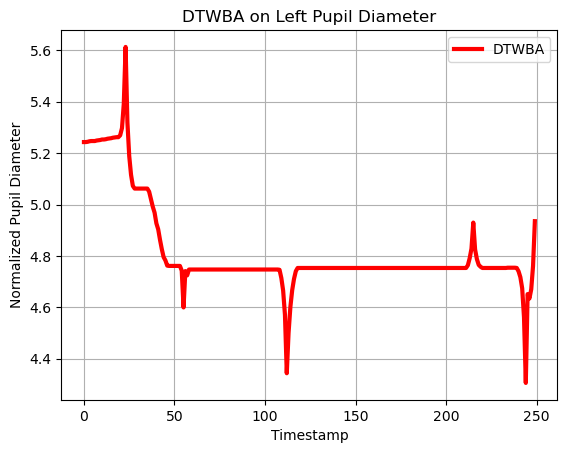

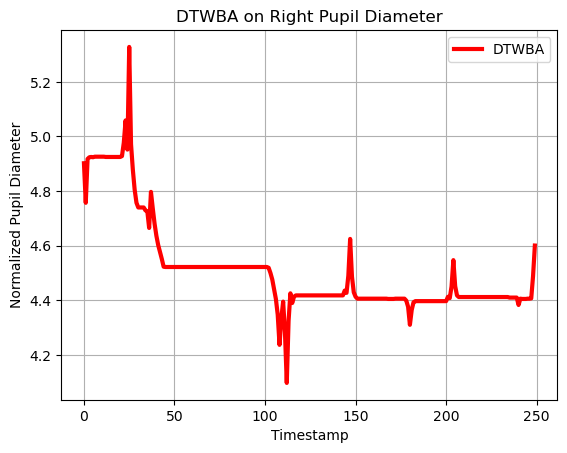

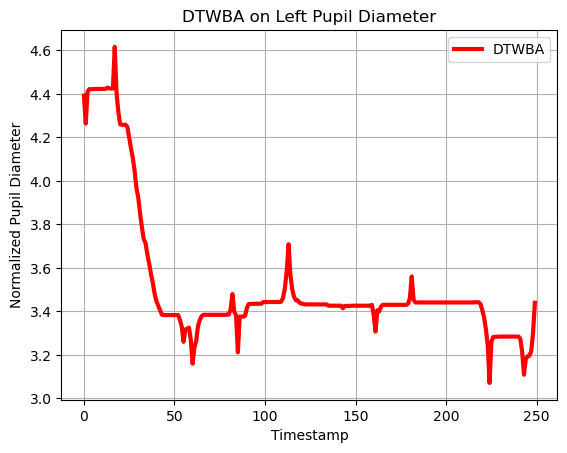

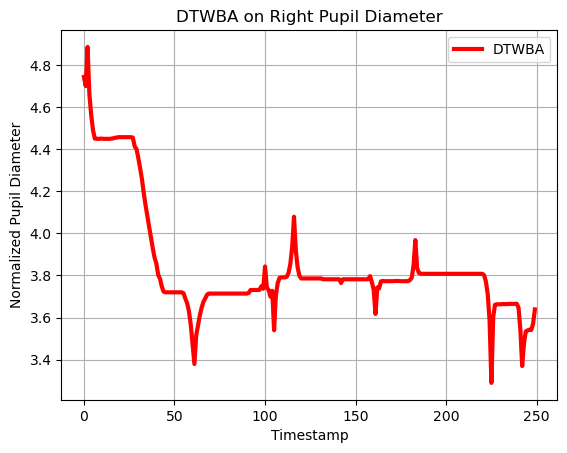

[Info] Experiment 0, Color Combination 0, Participant 0 with Participant 1: Done
[Info] Left EER: 0.0, Right EER: 0.0


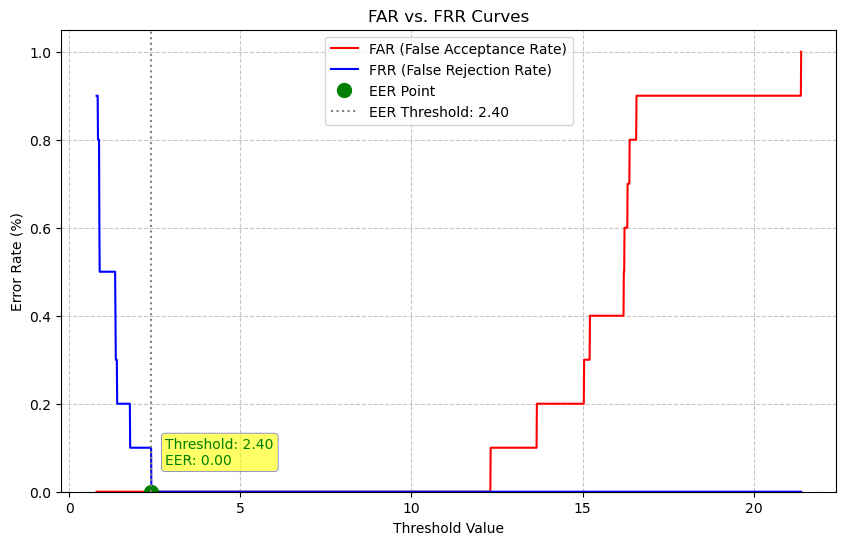

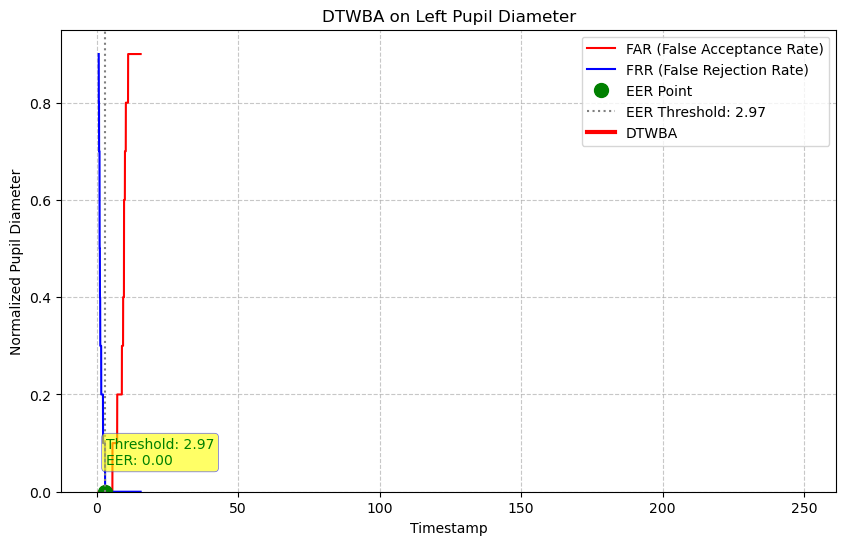

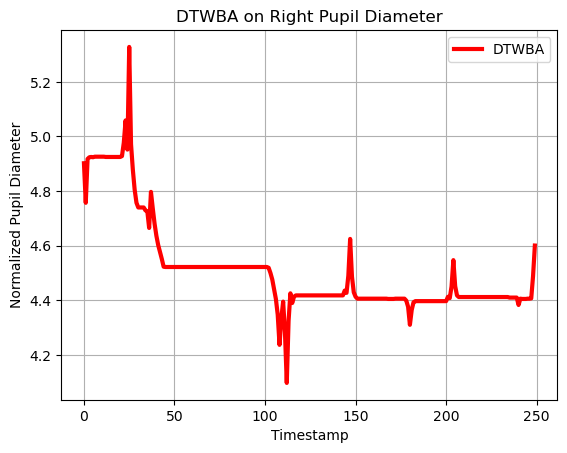

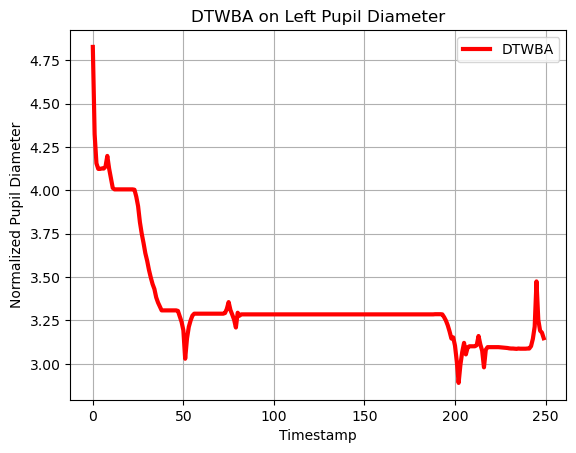

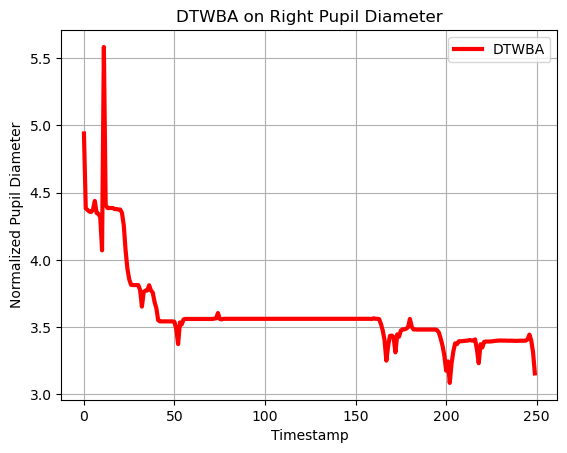

[Info] Experiment 0, Color Combination 0, Participant 0 with Participant 2: Done
[Info] Left EER: 0.0, Right EER: 0.0


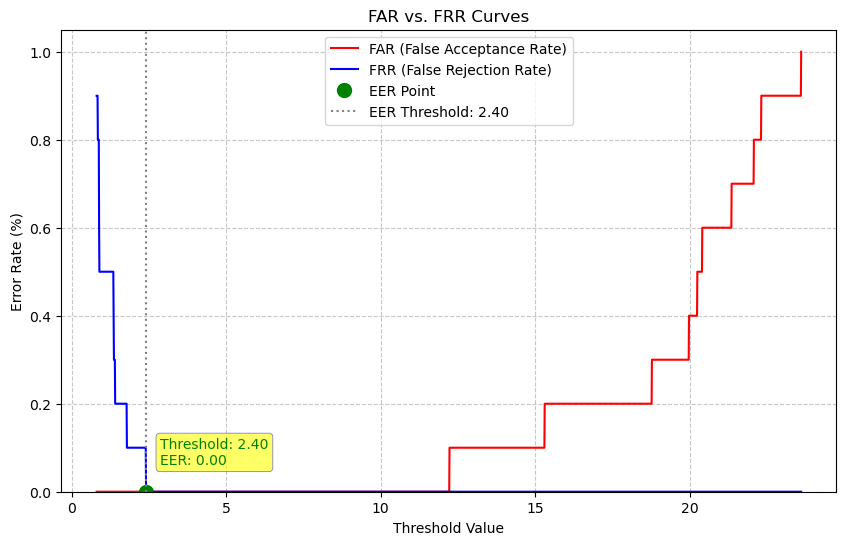

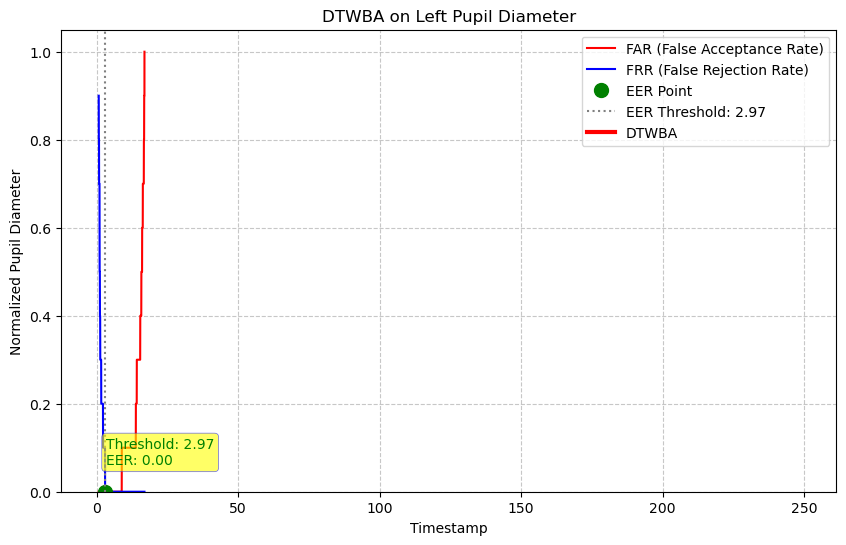

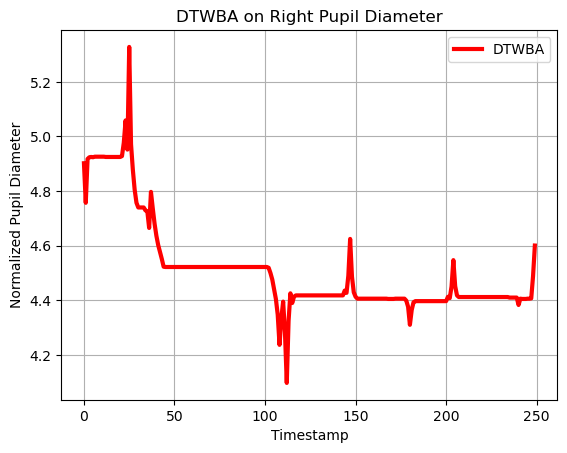

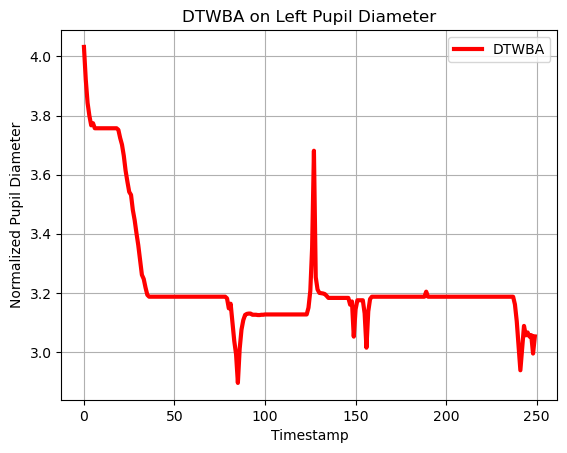

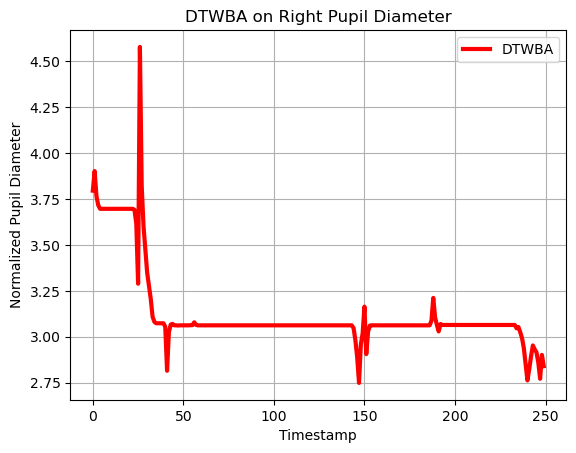

[Info] Experiment 0, Color Combination 0, Participant 0 with Participant 3: Done
[Info] Left EER: 0.0, Right EER: 0.0


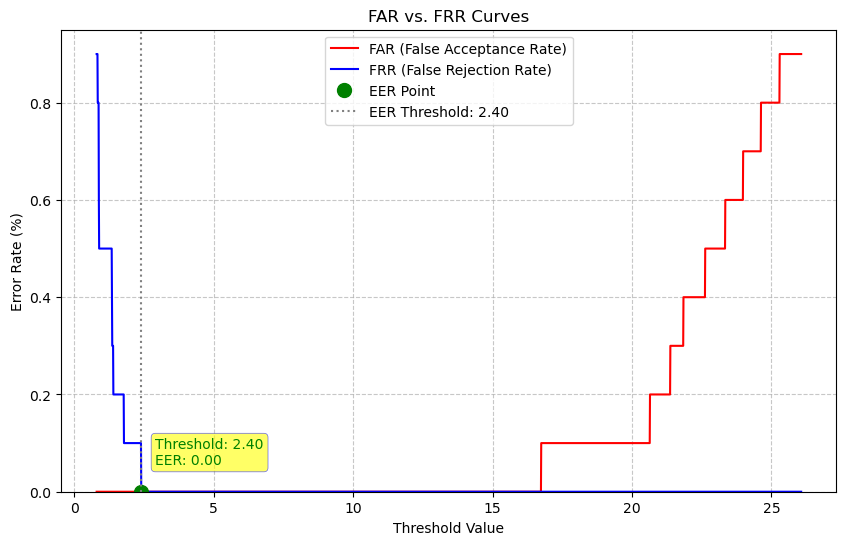

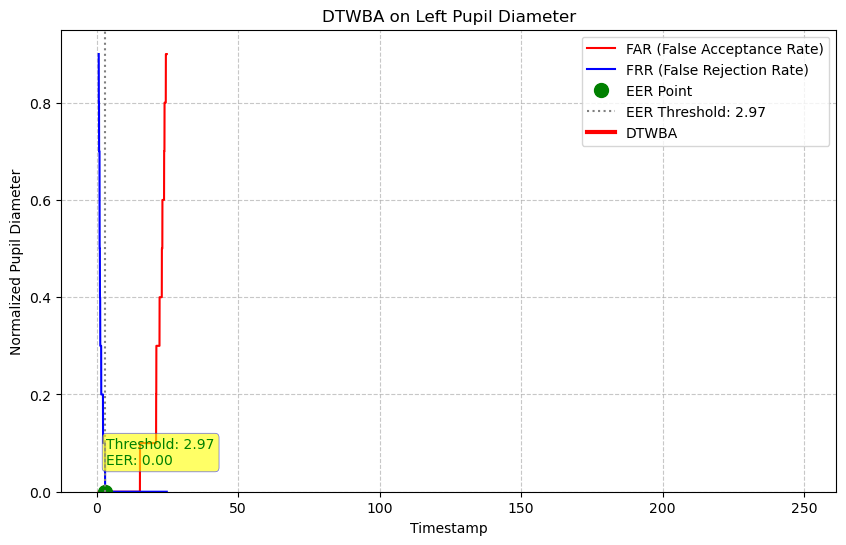

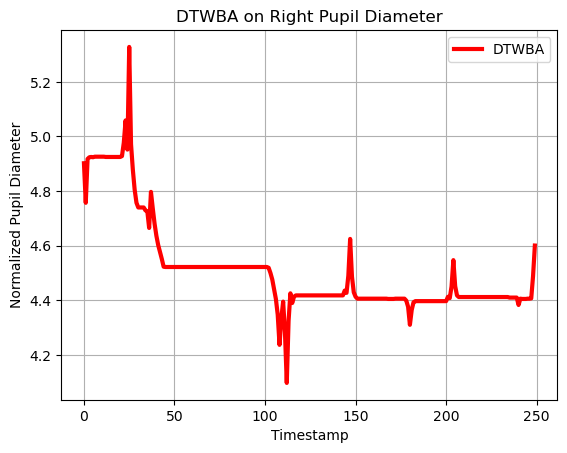

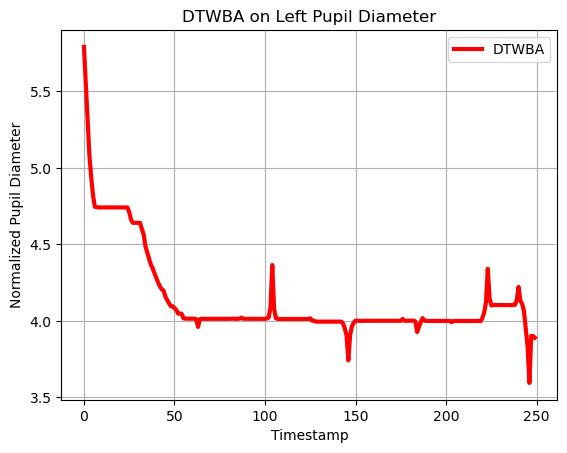

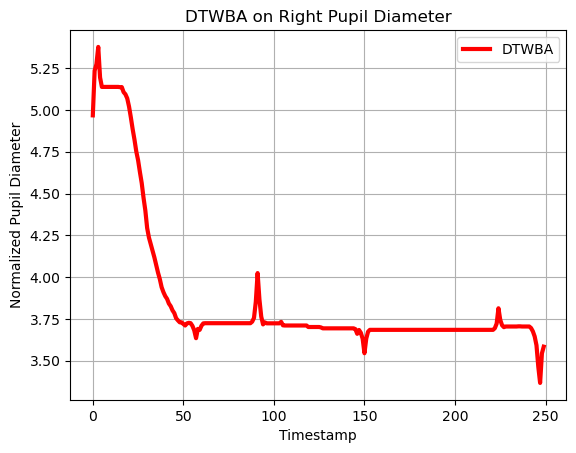

[Info] Experiment 0, Color Combination 0, Participant 0 with Participant 4: Done
[Info] Left EER: 0.0, Right EER: 0.0


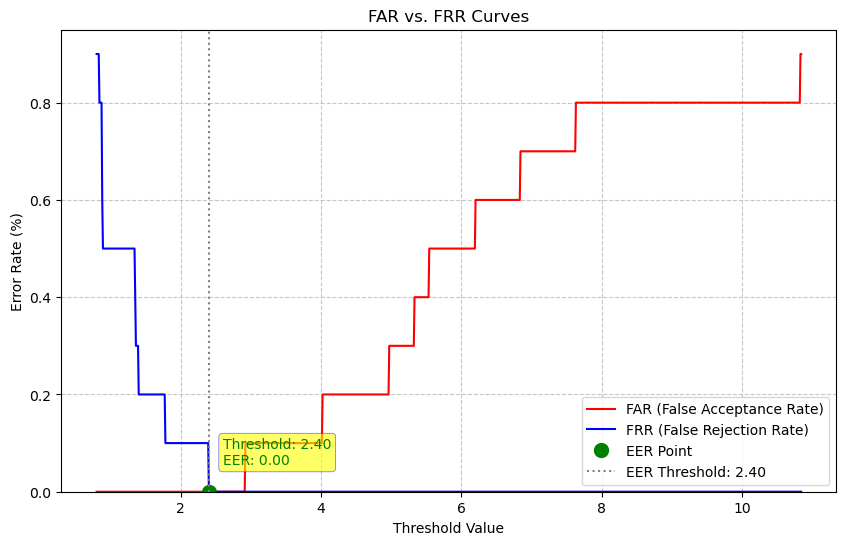

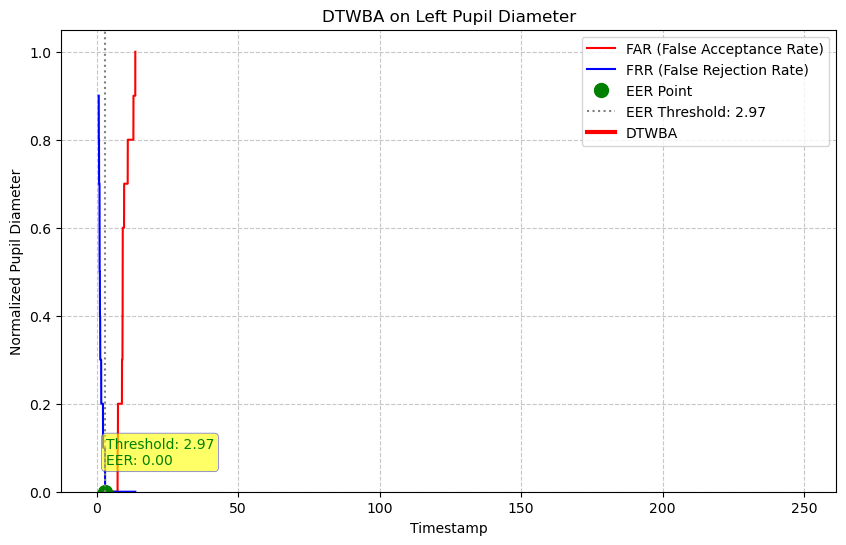

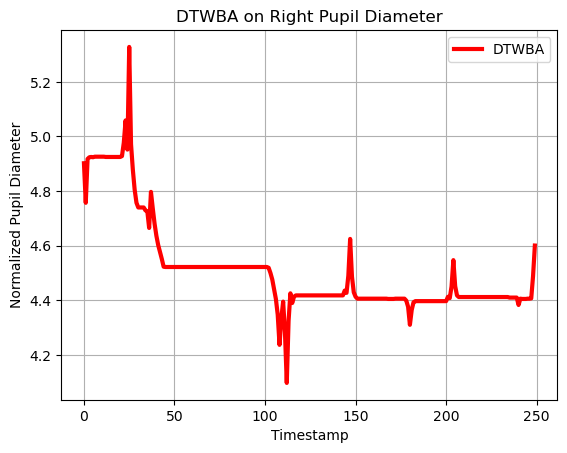

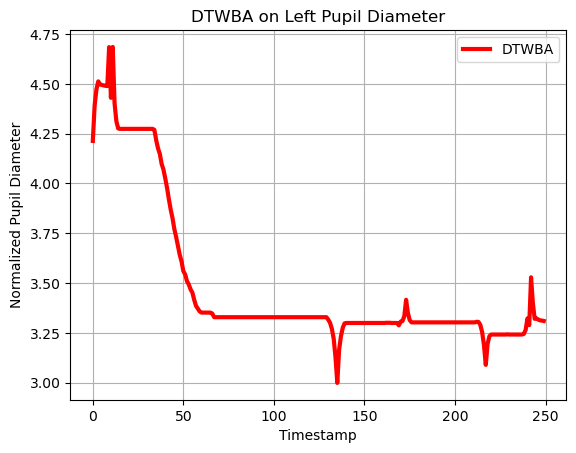

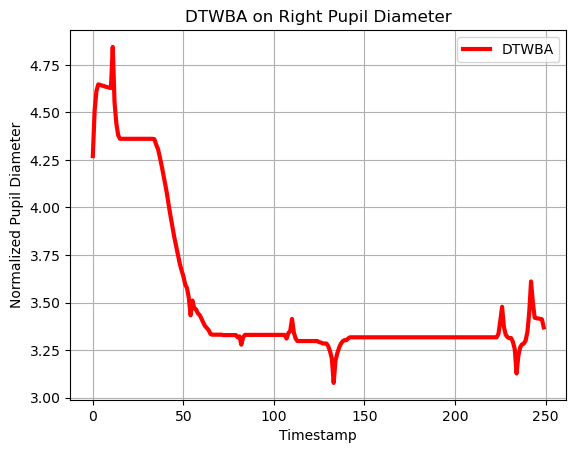

[Info] Experiment 0, Color Combination 0, Participant 0 with Participant 5: Done
[Info] Left EER: 0.0, Right EER: 0.0
[Info] participant_index: 0: Done


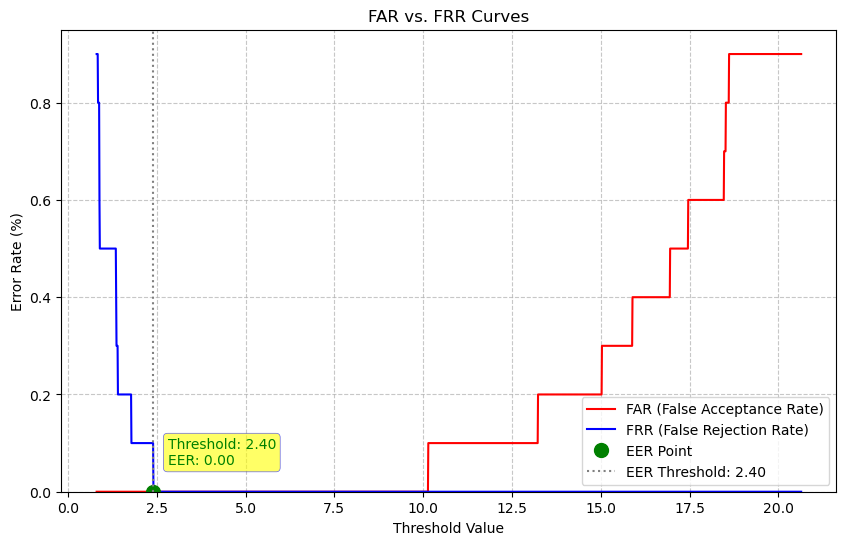

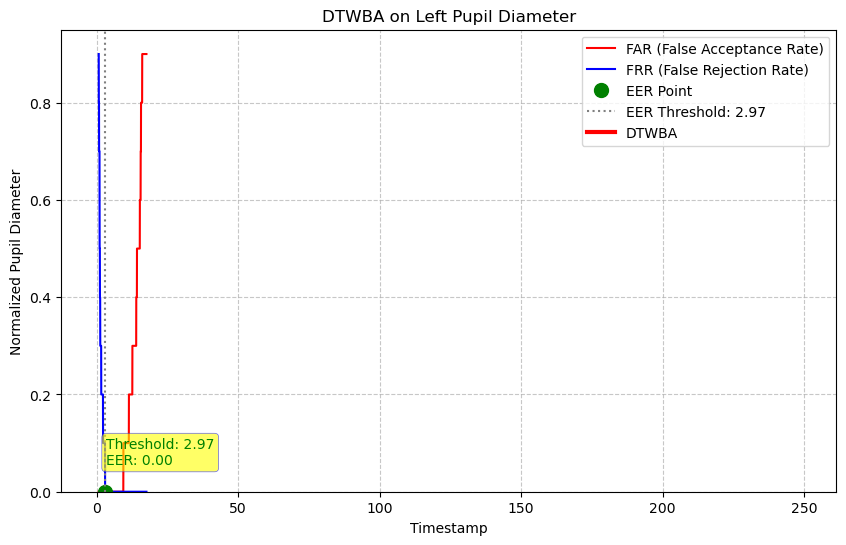

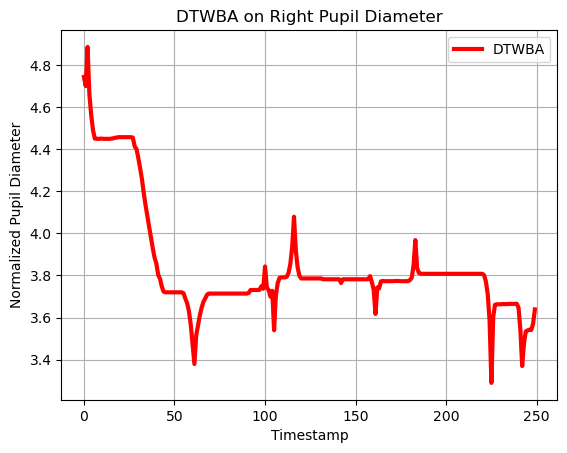

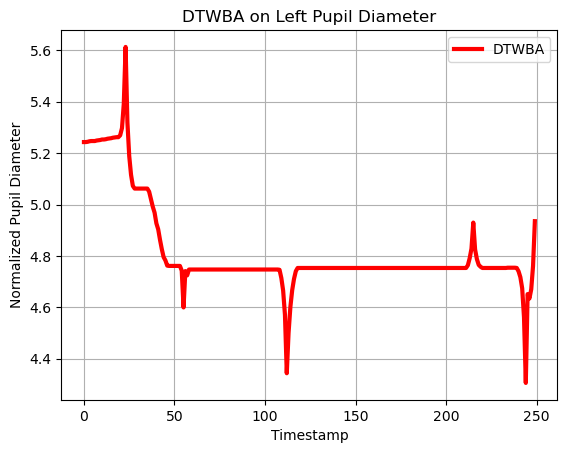

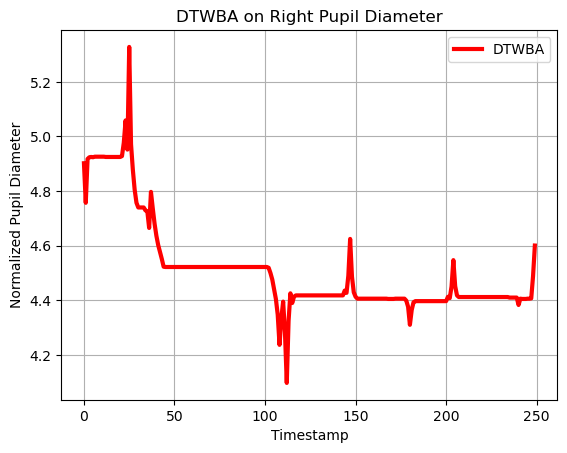

[Info] Experiment 0, Color Combination 0, Participant 1 with Participant 0: Done
[Info] Left EER: 0.0, Right EER: 0.0


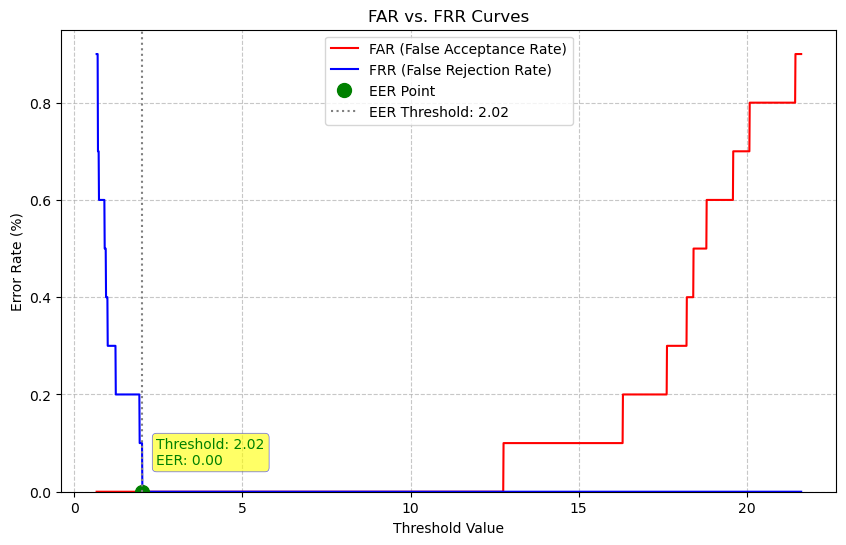

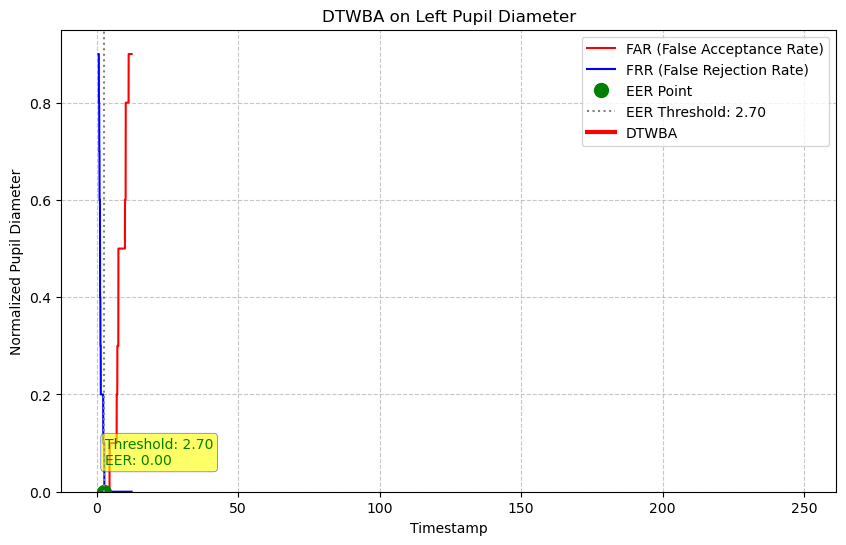

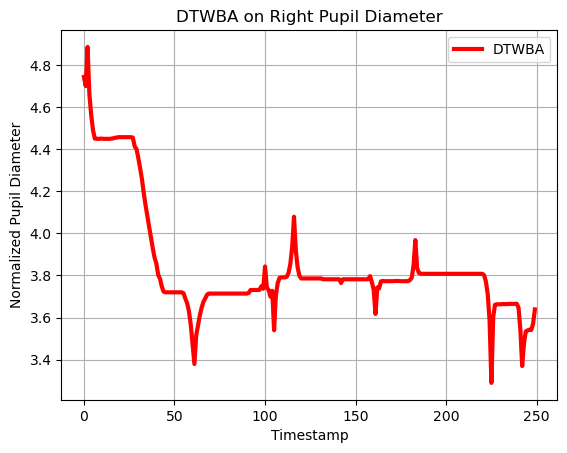

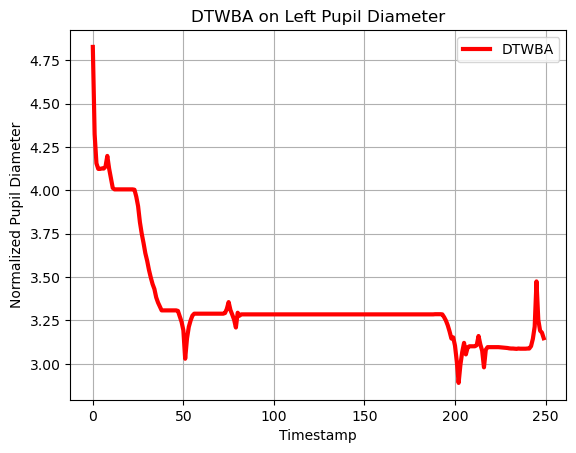

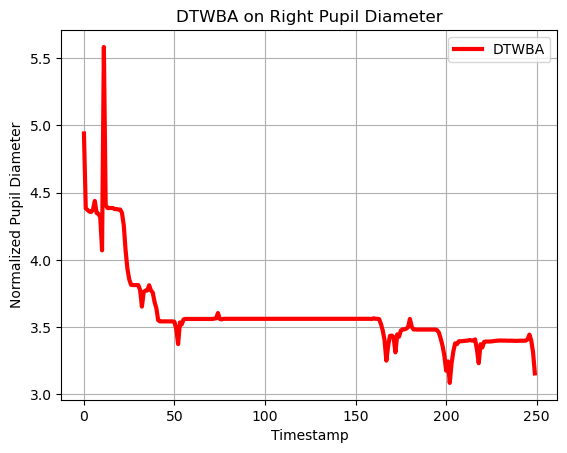

[Info] Experiment 0, Color Combination 0, Participant 1 with Participant 2: Done
[Info] Left EER: 0.2, Right EER: 0.2


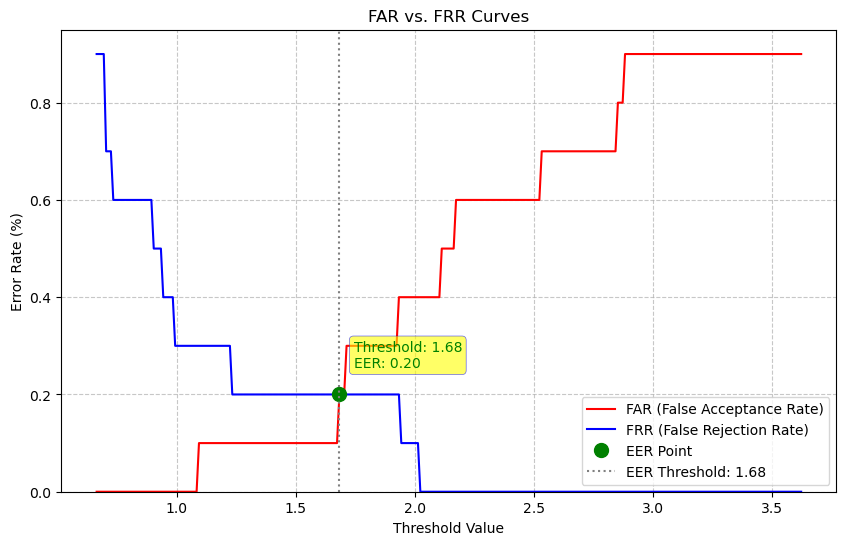

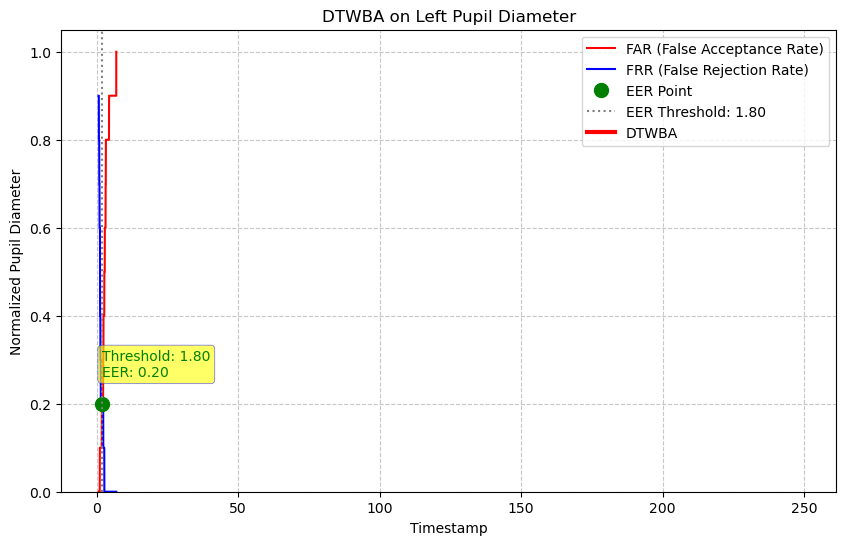

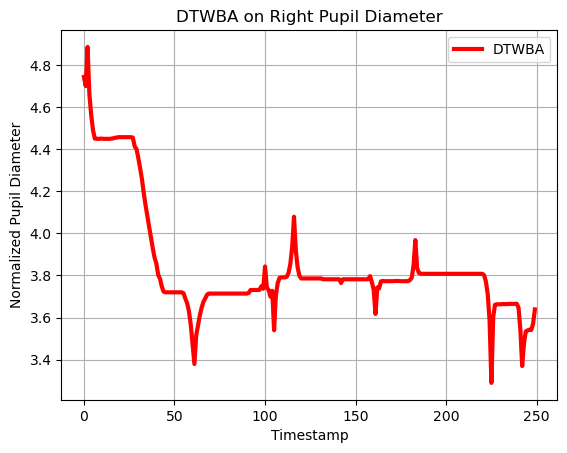

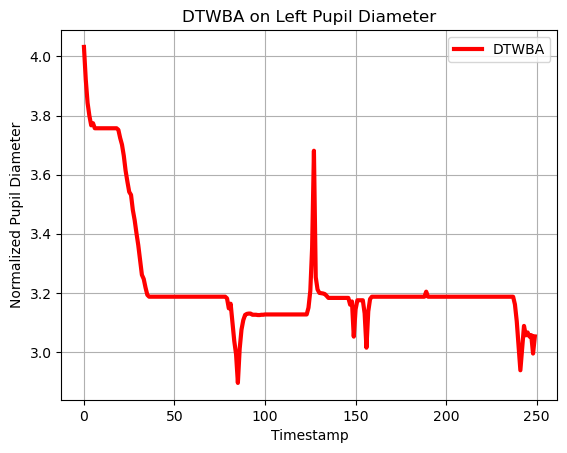

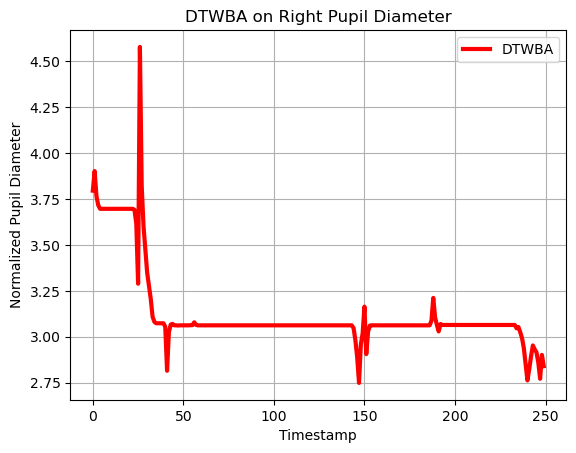

[Info] Experiment 0, Color Combination 0, Participant 1 with Participant 3: Done
[Info] Left EER: 0.1, Right EER: 0.0


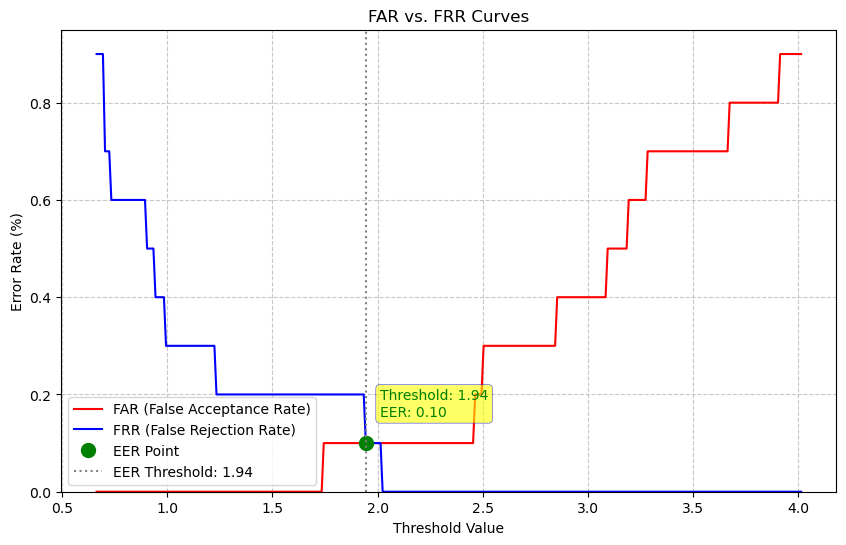

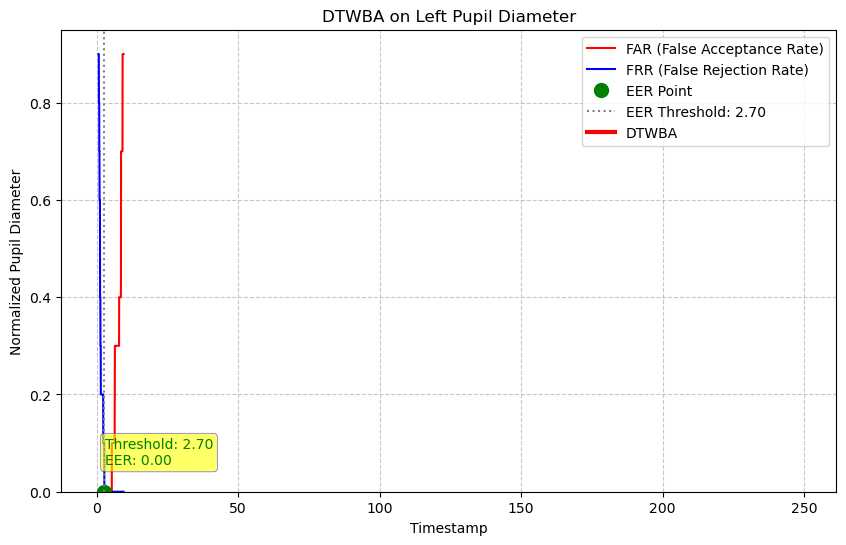

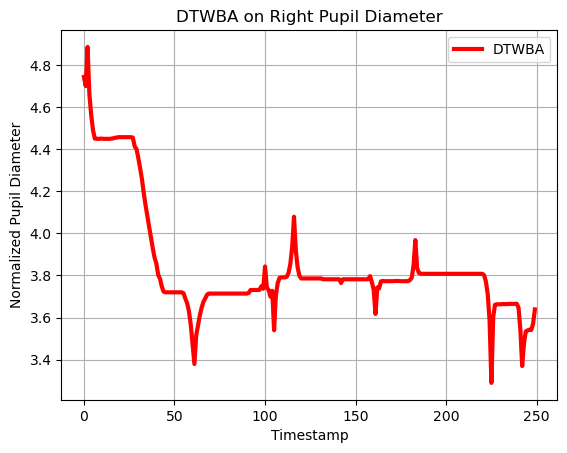

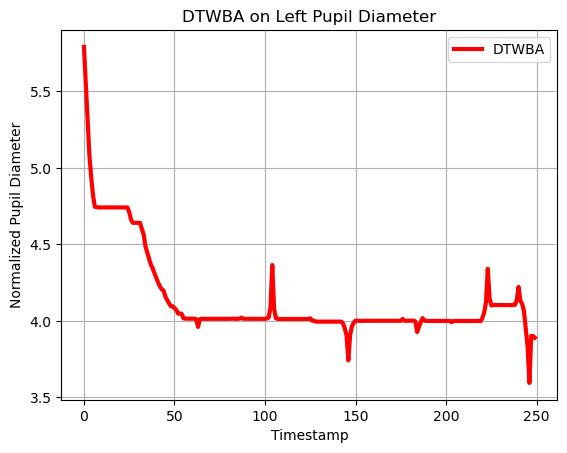

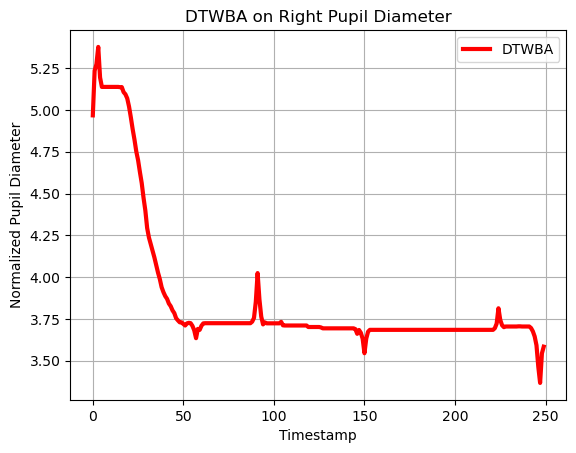

[Info] Experiment 0, Color Combination 0, Participant 1 with Participant 4: Done
[Info] Left EER: 0.0, Right EER: 0.2


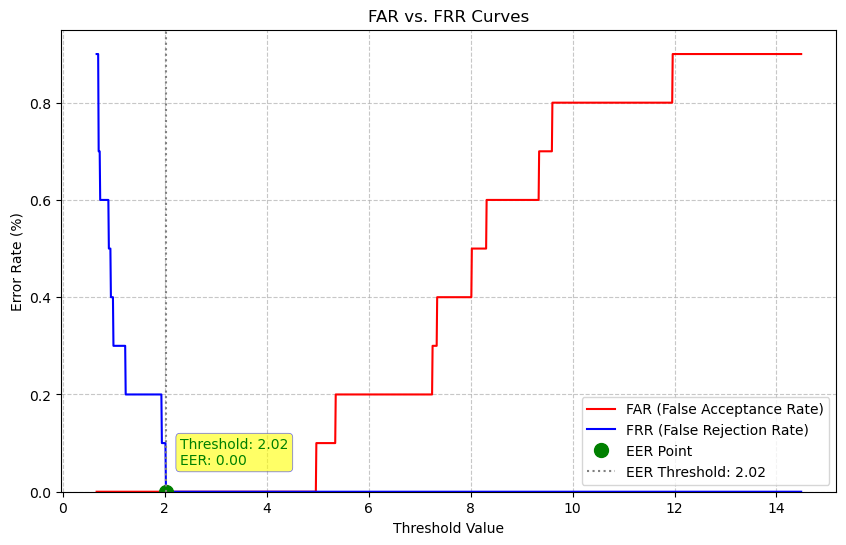

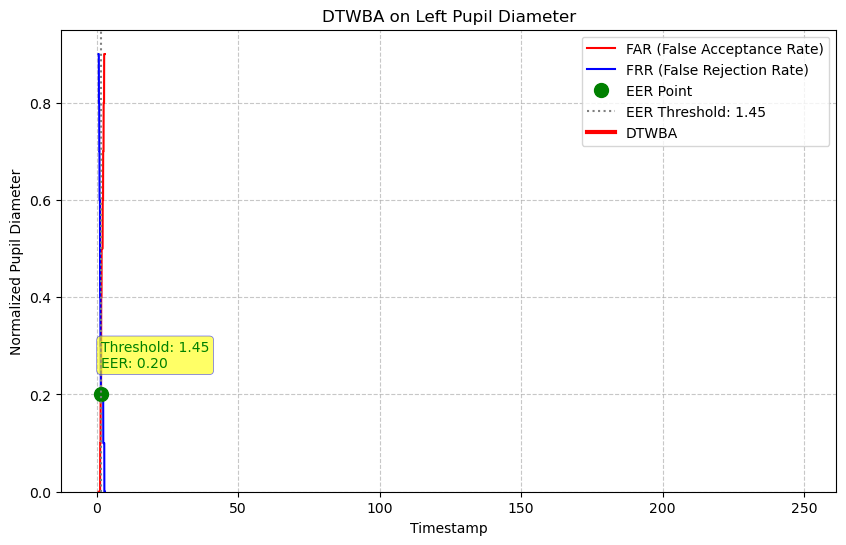

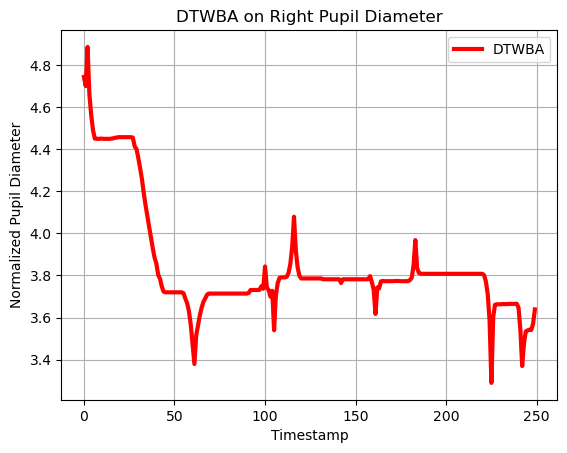

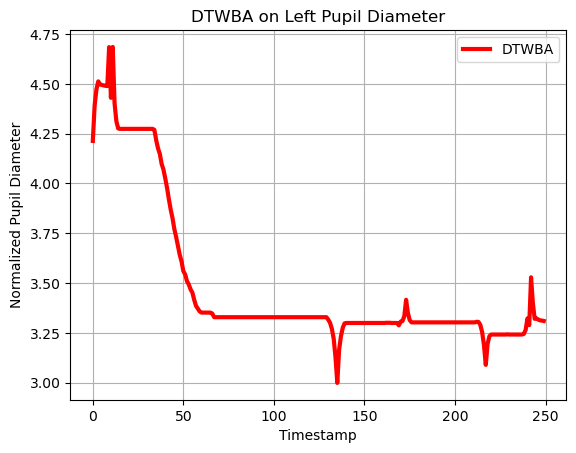

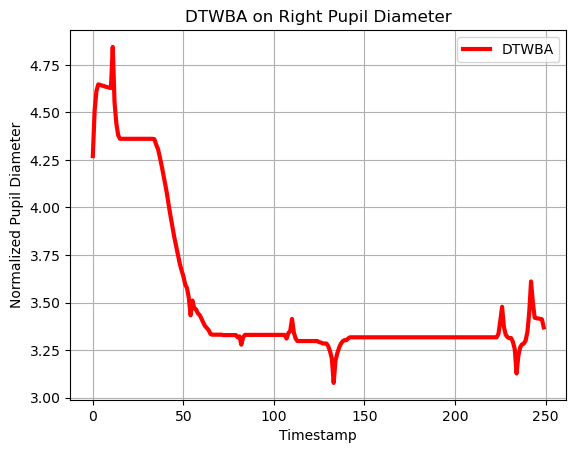

[Info] Experiment 0, Color Combination 0, Participant 1 with Participant 5: Done
[Info] Left EER: 0.3, Right EER: 0.2
[Info] participant_index: 1: Done


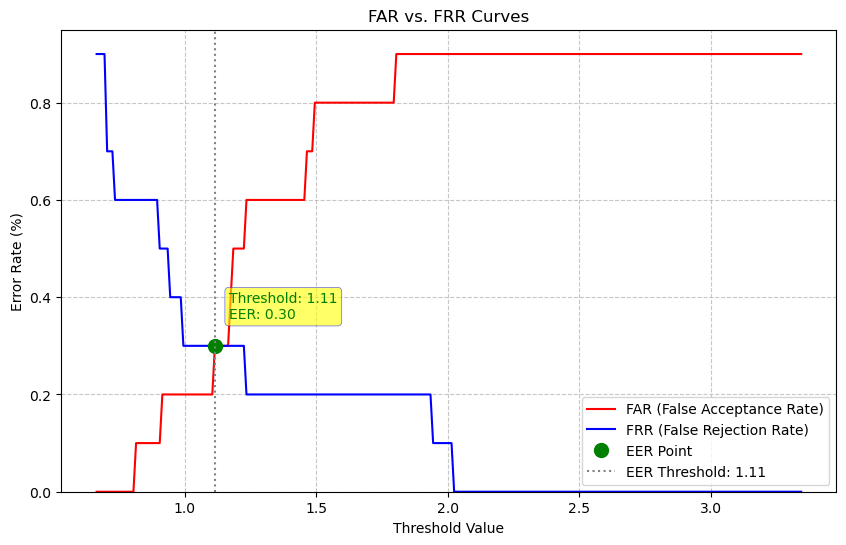

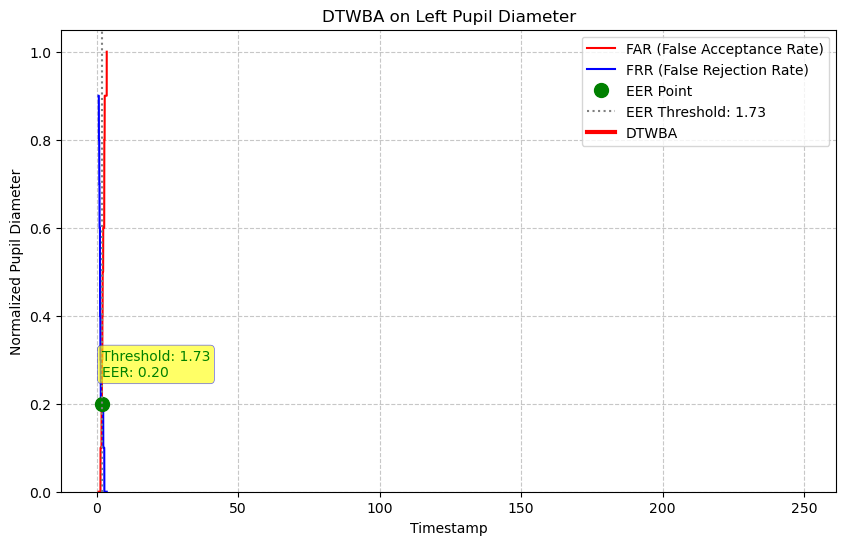

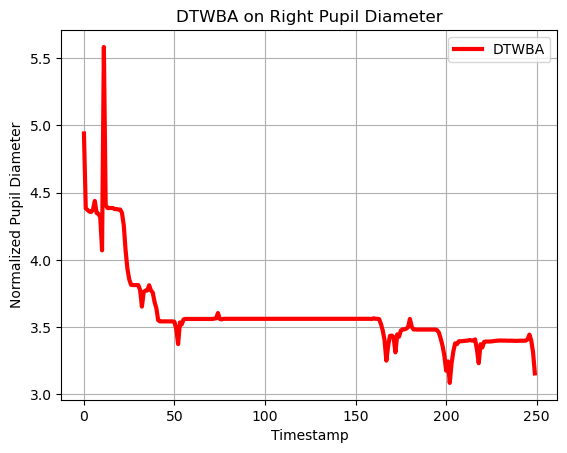

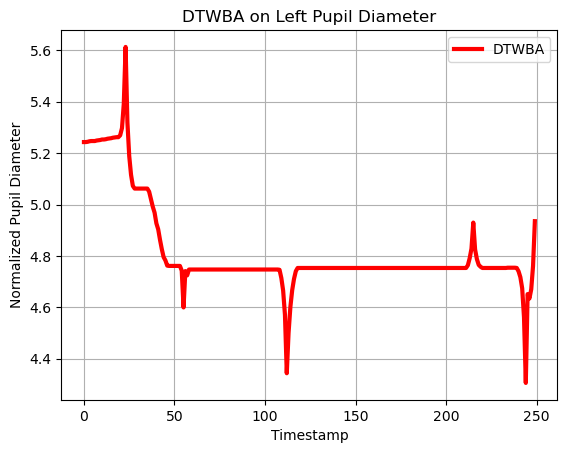

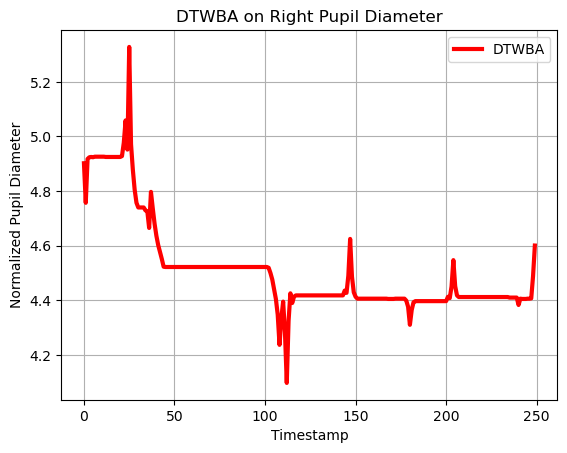

[Info] Experiment 0, Color Combination 0, Participant 2 with Participant 0: Done
[Info] Left EER: 0.0, Right EER: 0.0


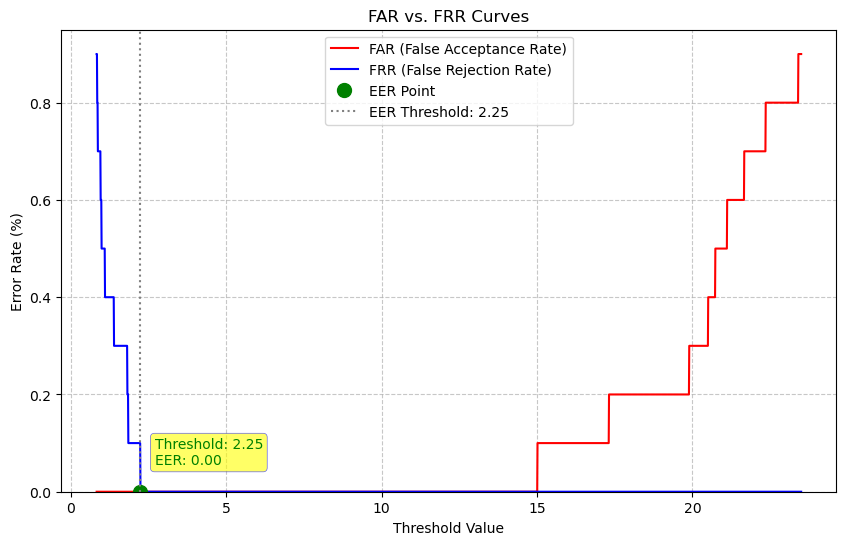

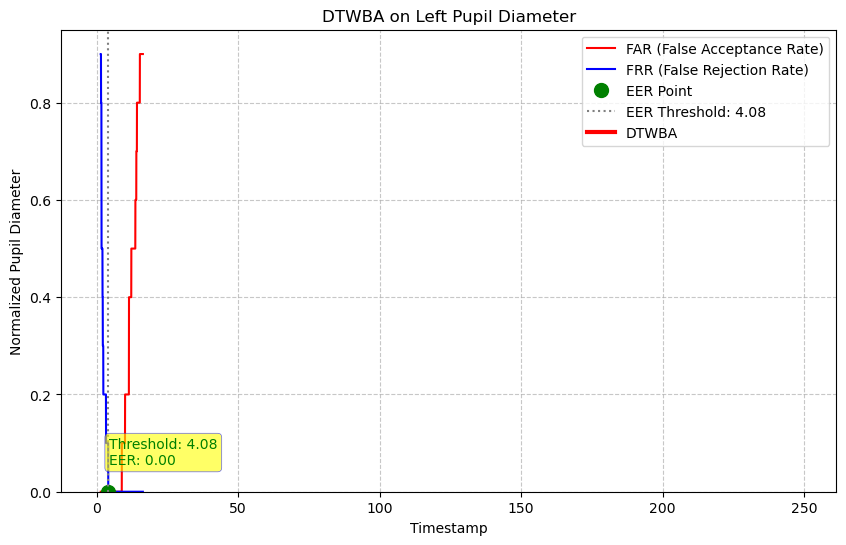

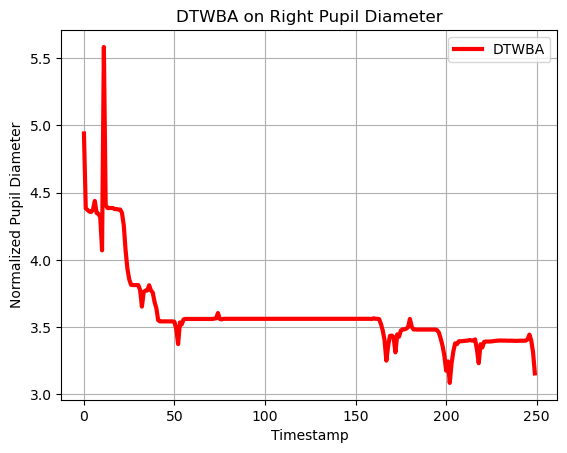

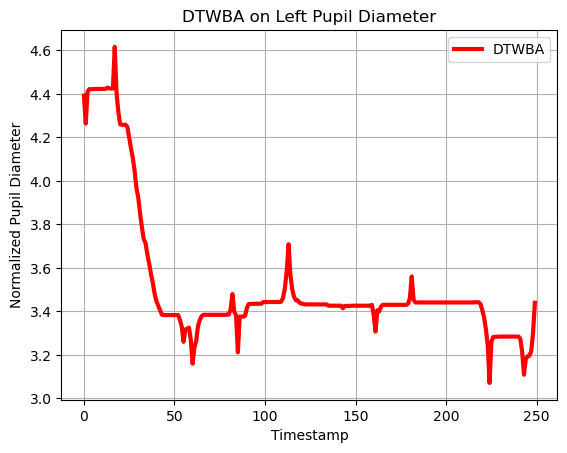

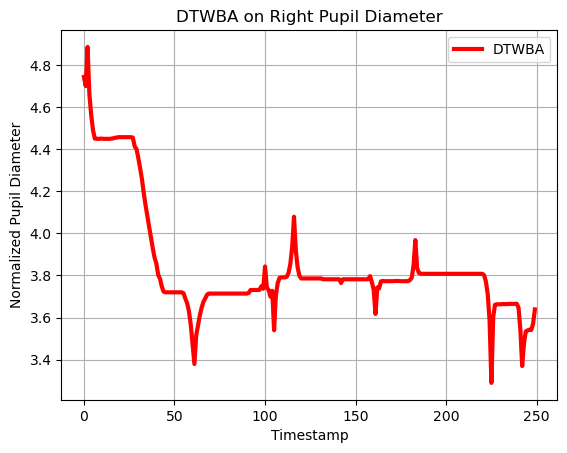

[Info] Experiment 0, Color Combination 0, Participant 2 with Participant 1: Done
[Info] Left EER: 0.3, Right EER: 0.3


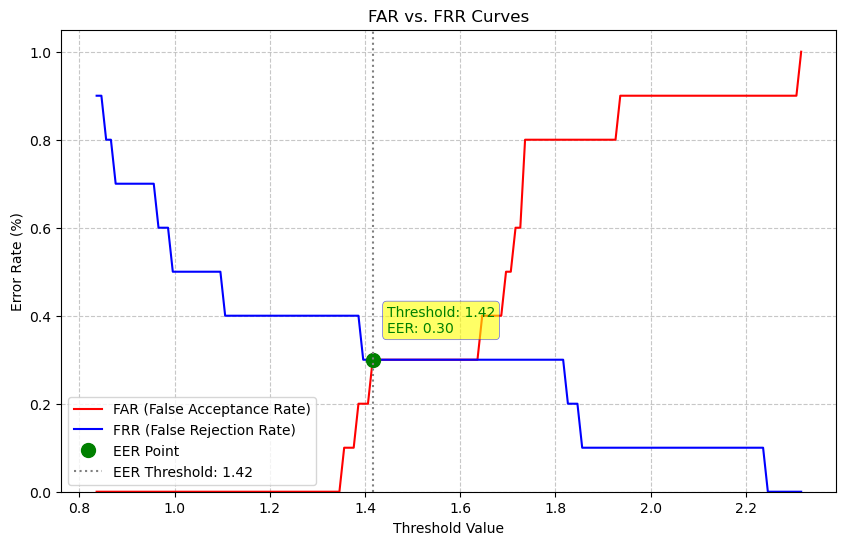

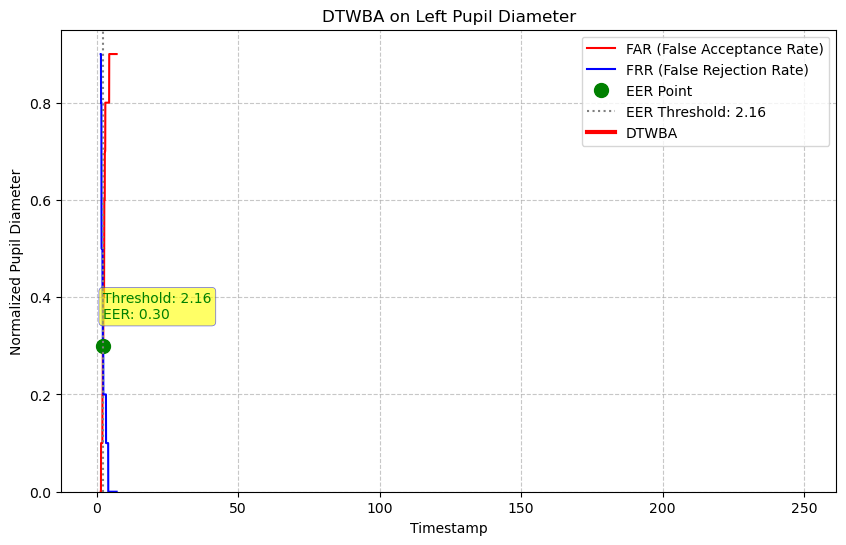

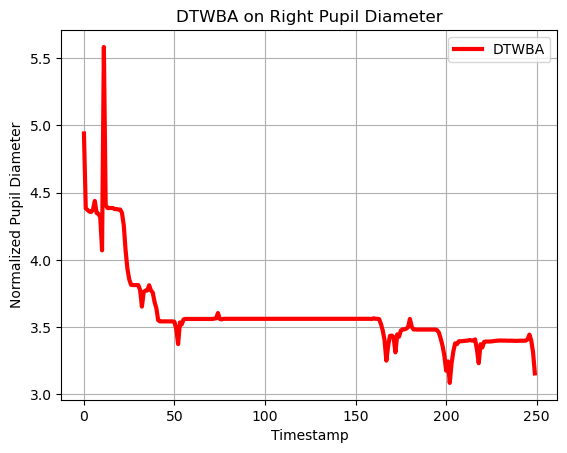

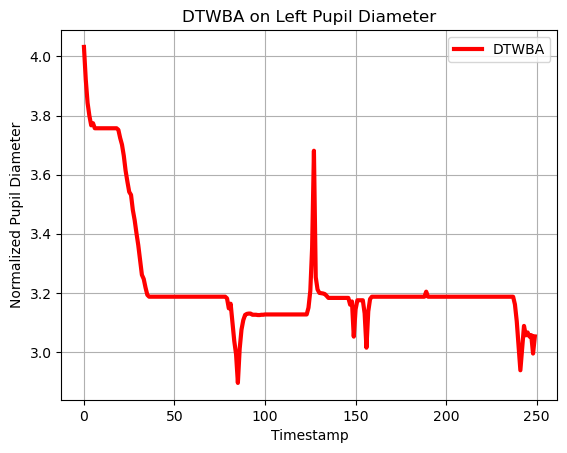

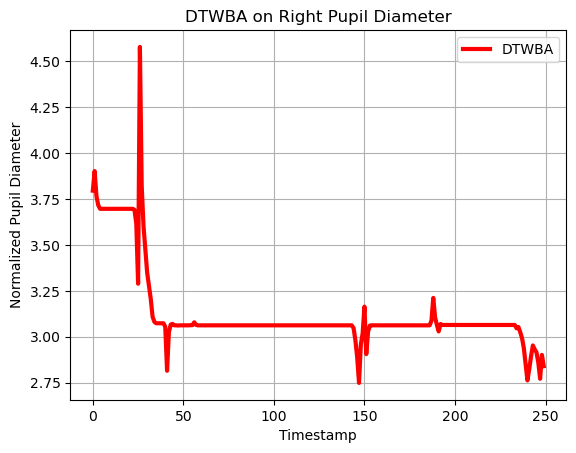

[Info] Experiment 0, Color Combination 0, Participant 2 with Participant 3: Done
[Info] Left EER: 0.3, Right EER: 0.1


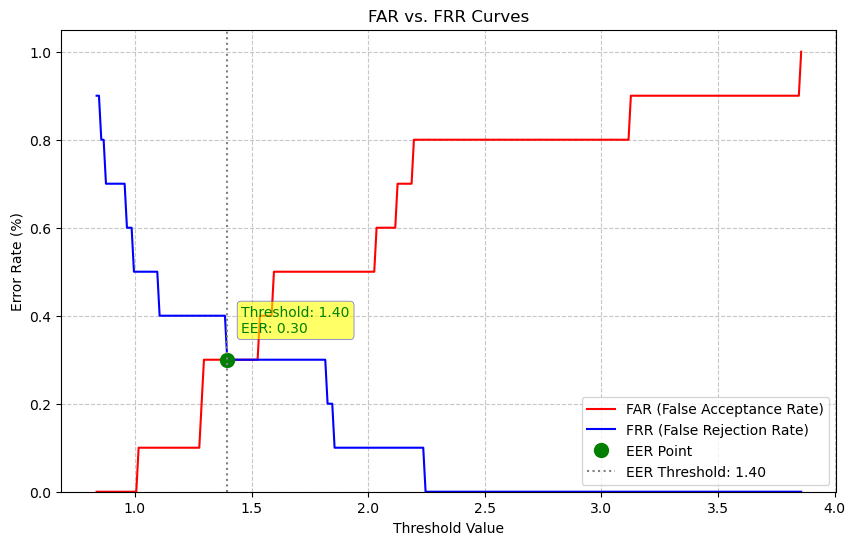

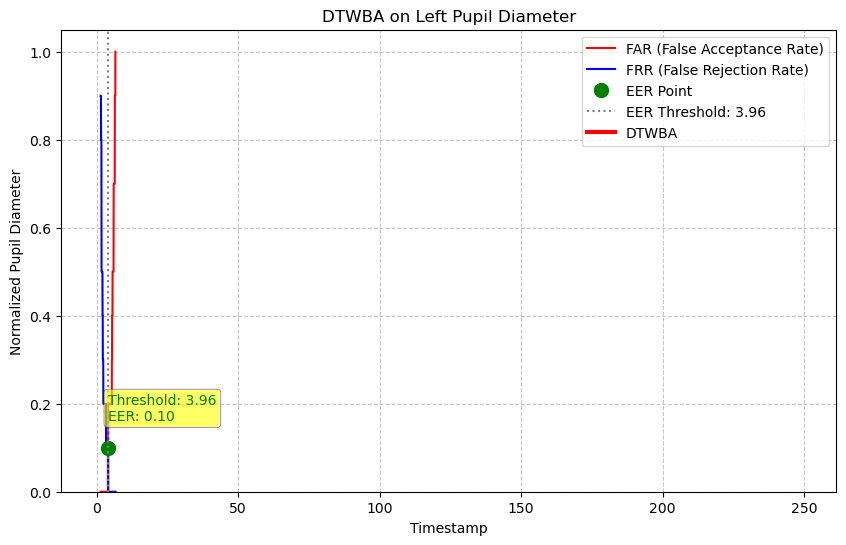

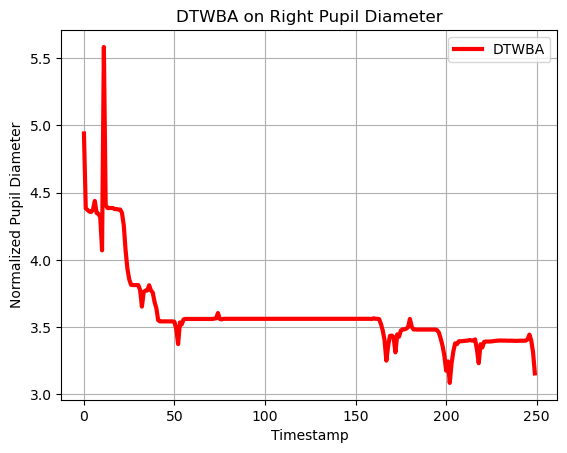

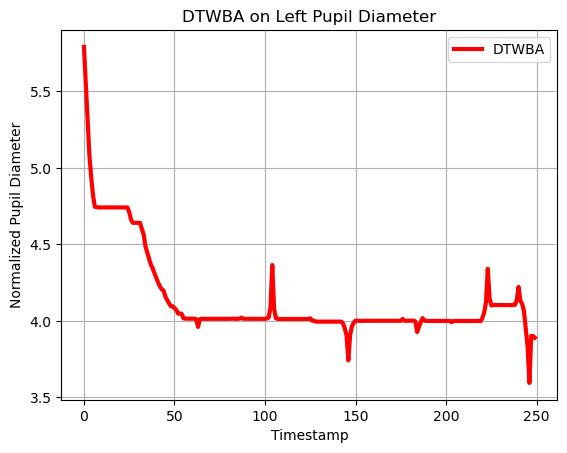

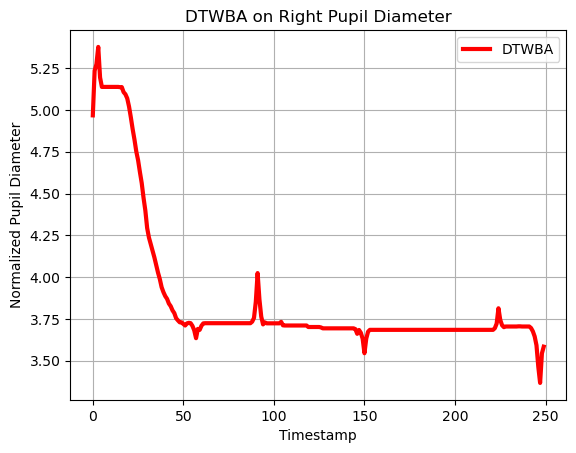

[Info] Experiment 0, Color Combination 0, Participant 2 with Participant 4: Done
[Info] Left EER: 0.0, Right EER: 0.4


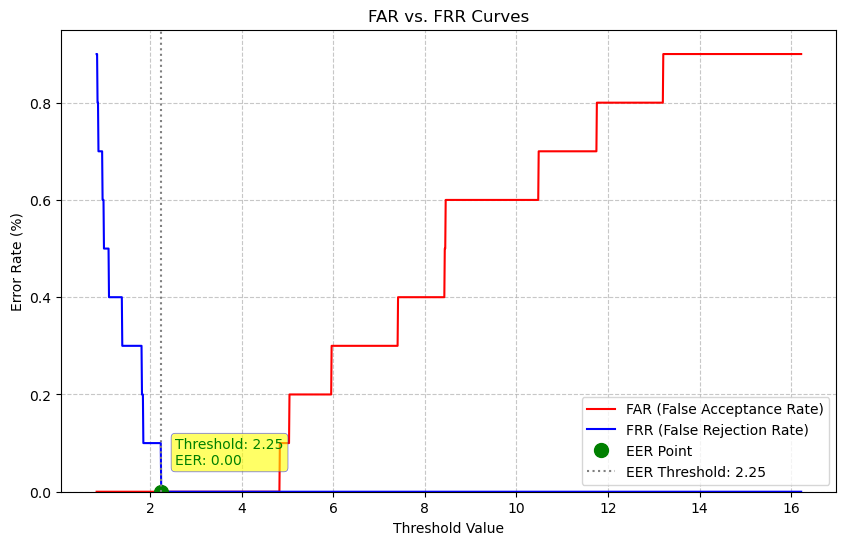

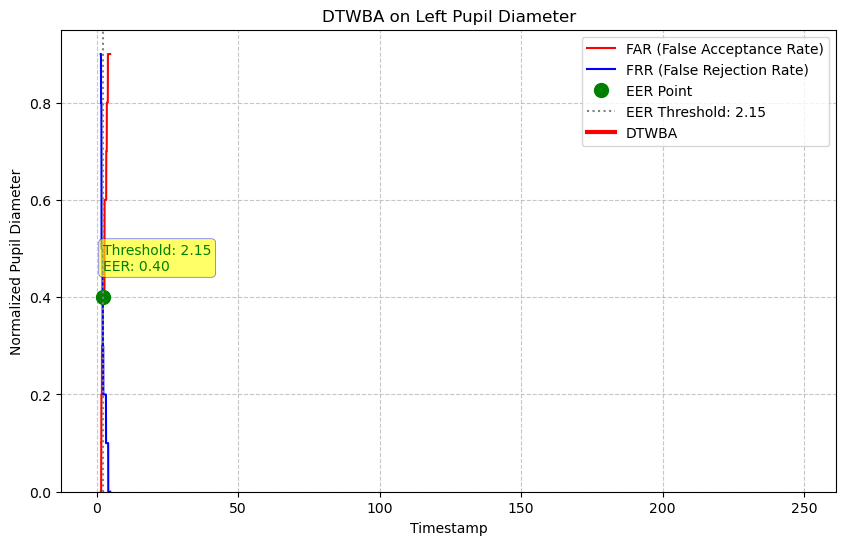

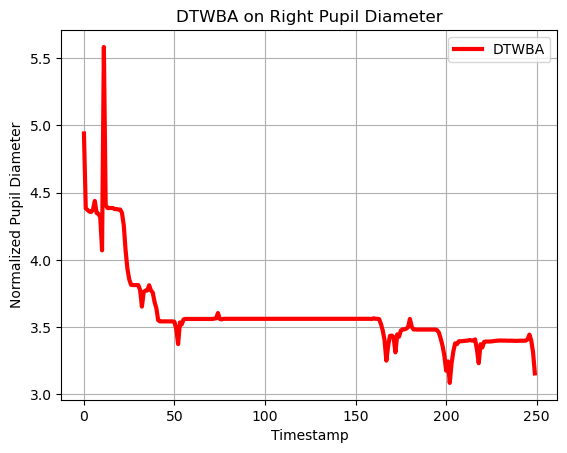

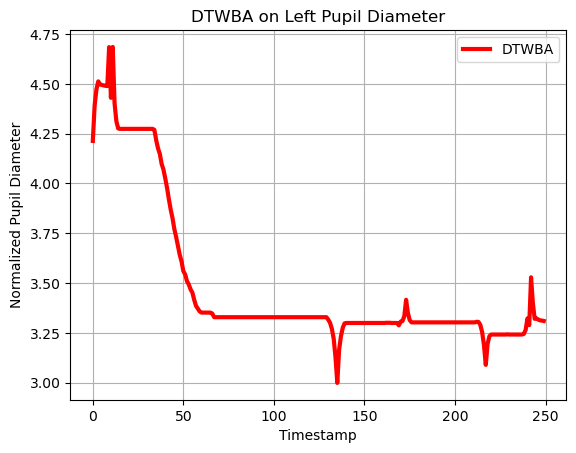

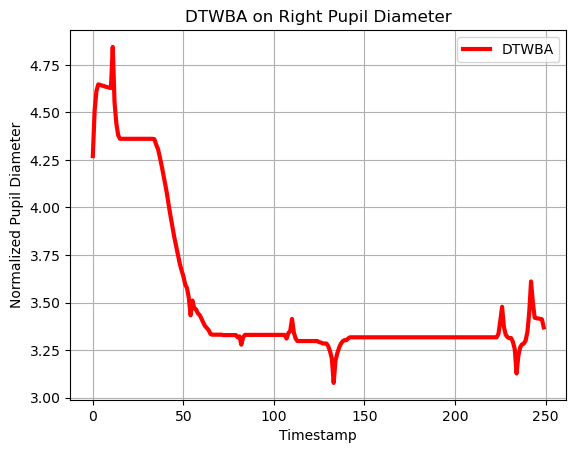

[Info] Experiment 0, Color Combination 0, Participant 2 with Participant 5: Done
[Info] Left EER: 0.5, Right EER: 0.5
[Info] participant_index: 2: Done


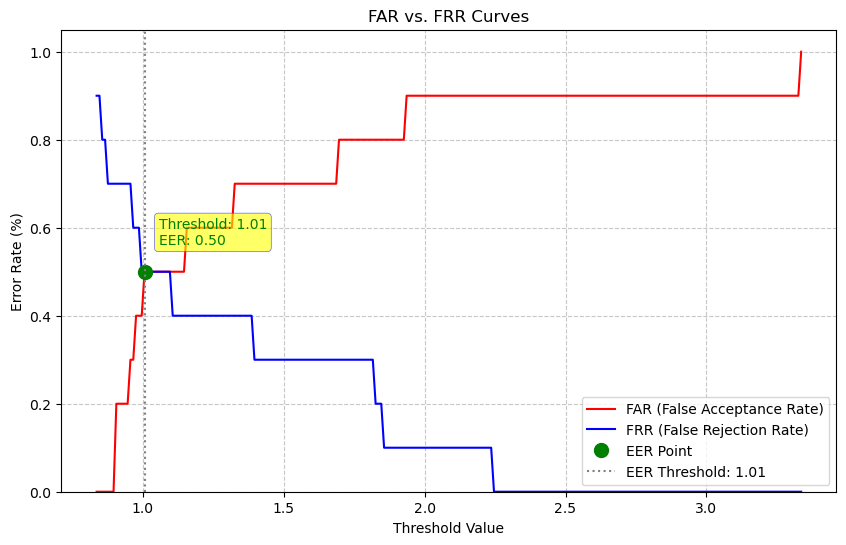

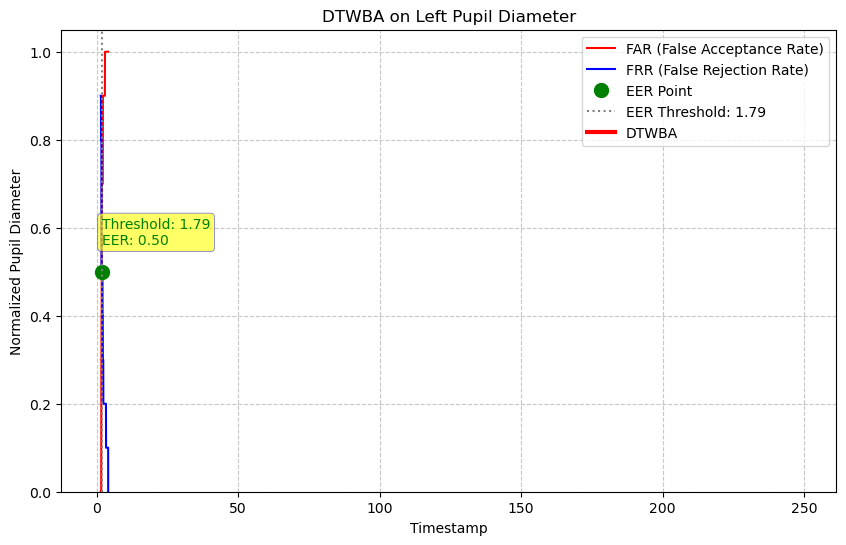

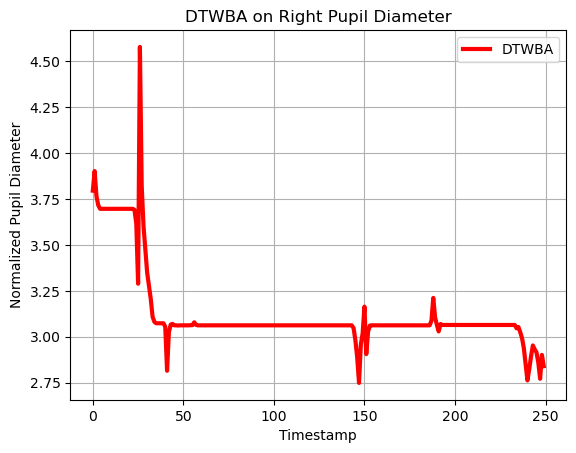

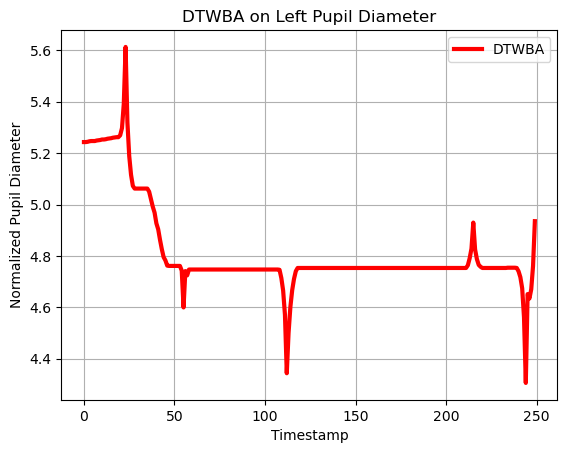

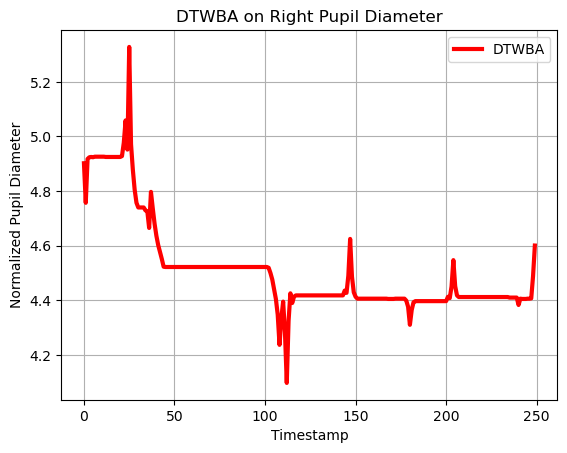

[Info] Experiment 0, Color Combination 0, Participant 3 with Participant 0: Done
[Info] Left EER: 0.0, Right EER: 0.0


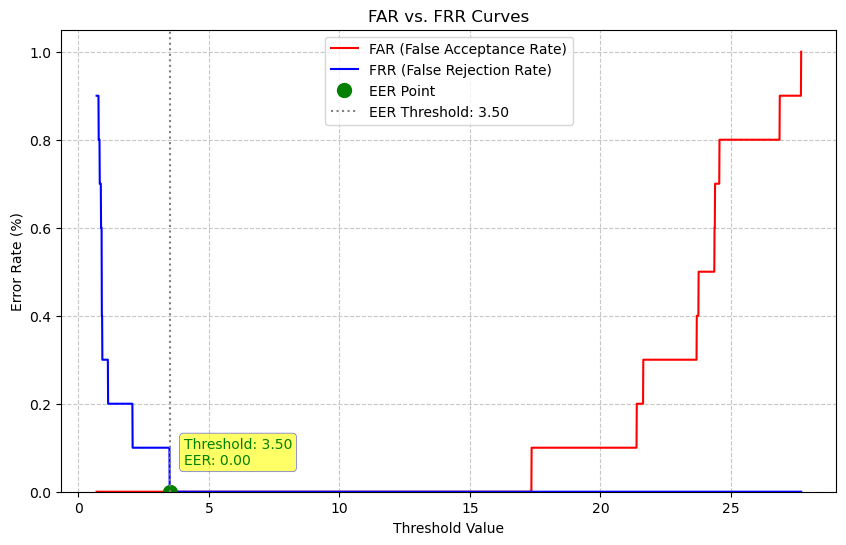

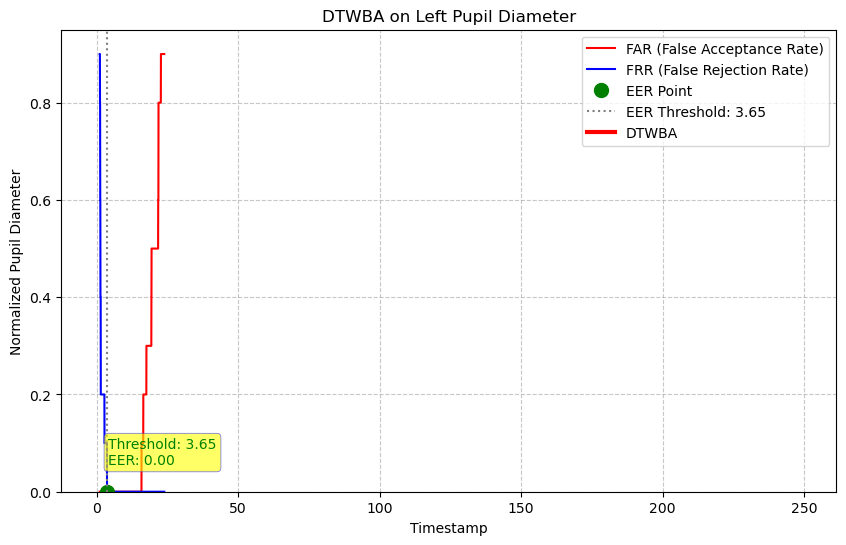

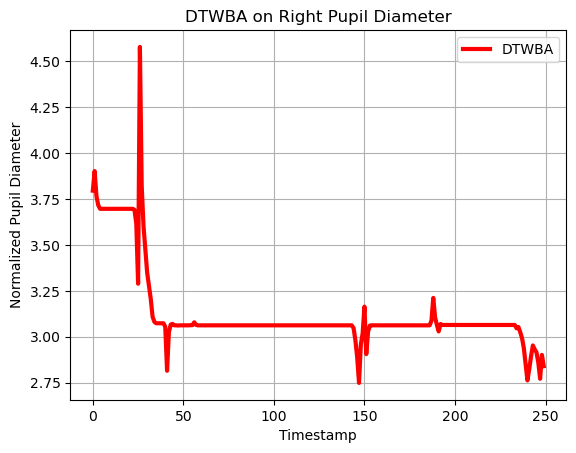

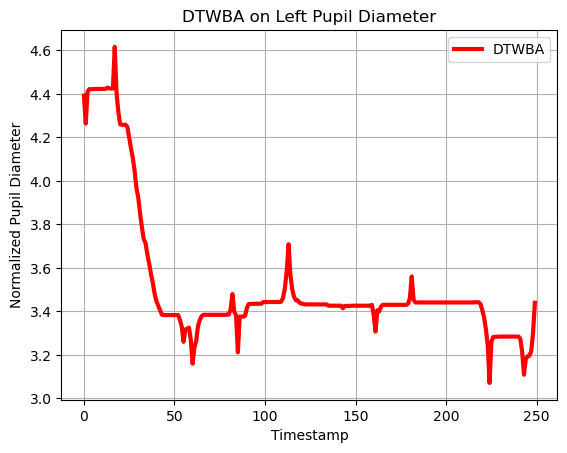

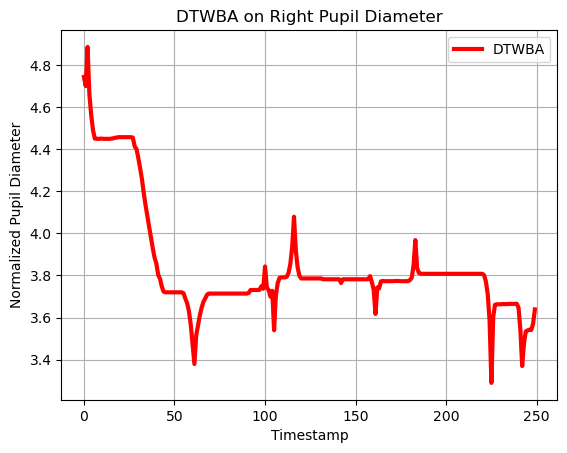

[Info] Experiment 0, Color Combination 0, Participant 3 with Participant 1: Done
[Info] Left EER: 0.2, Right EER: 0.1


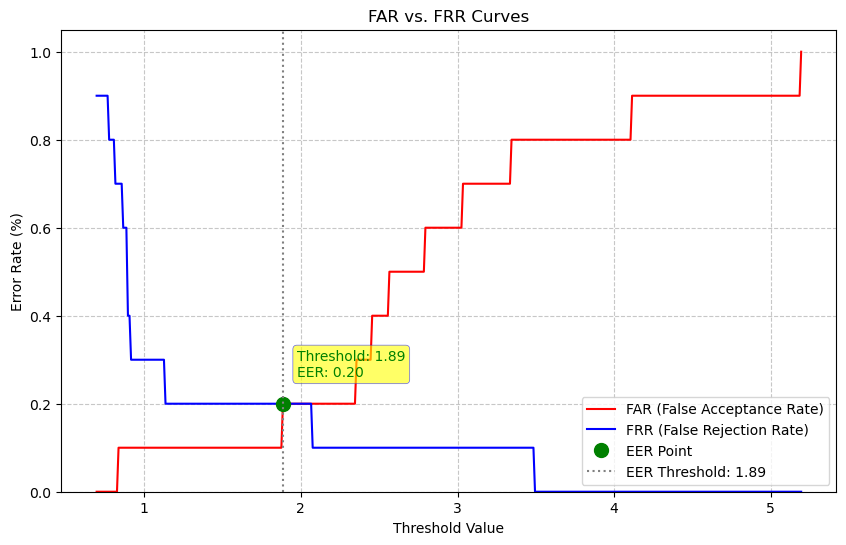

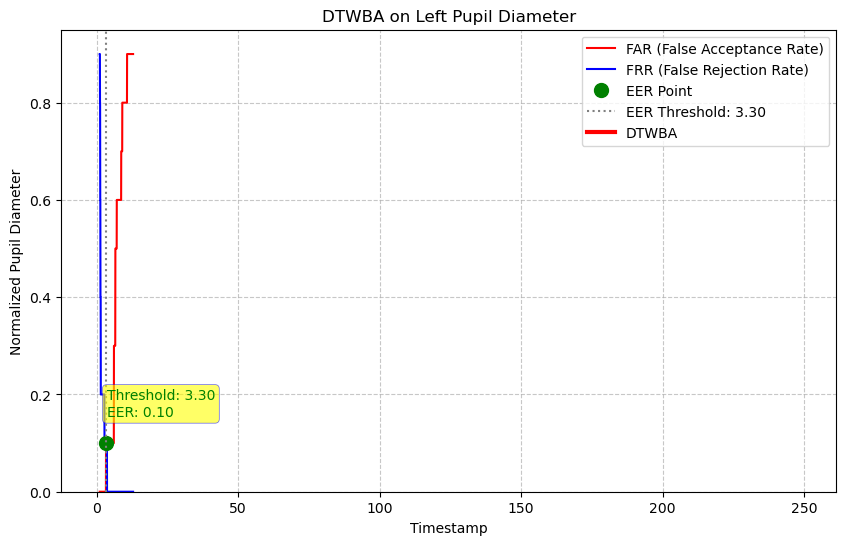

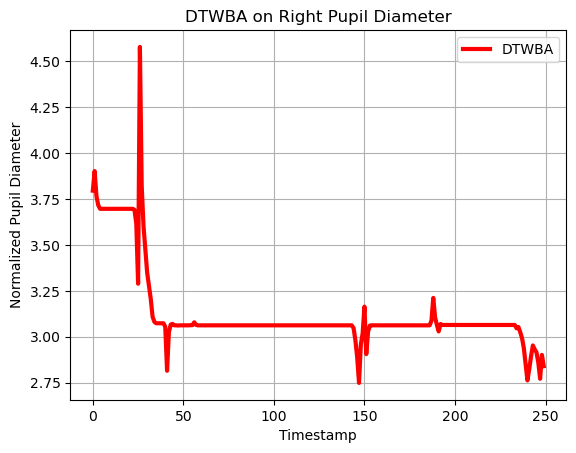

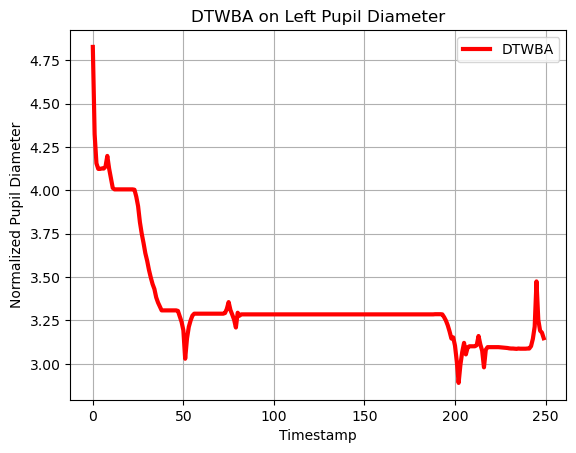

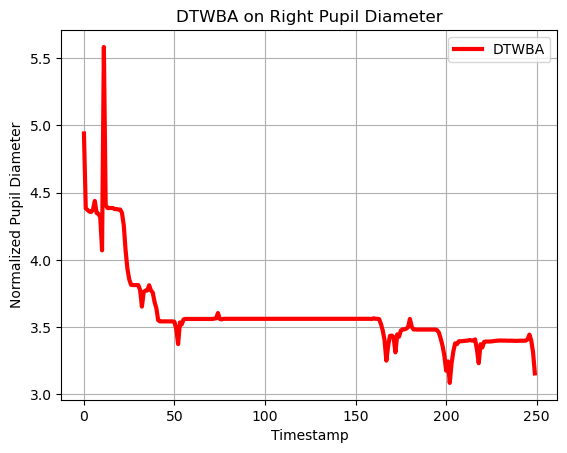

[Info] Experiment 0, Color Combination 0, Participant 3 with Participant 2: Done
[Info] Left EER: 0.3, Right EER: 0.1


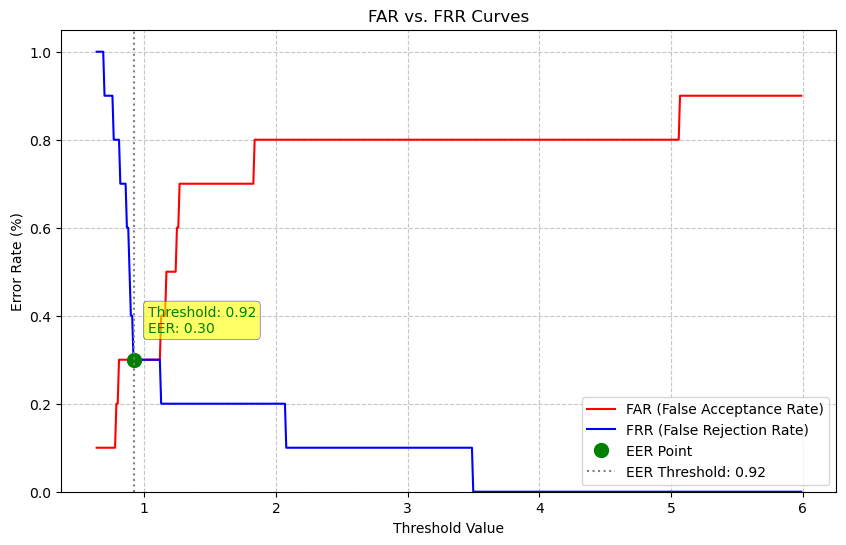

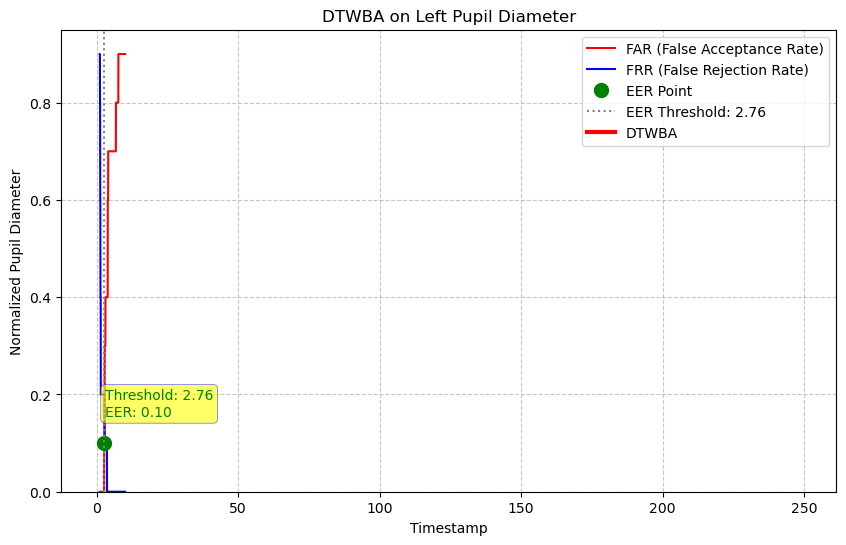

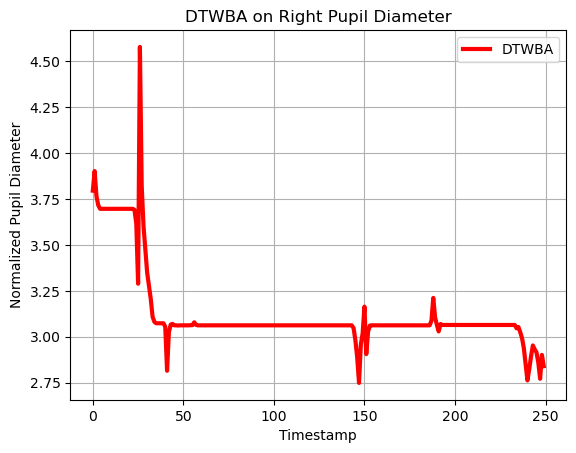

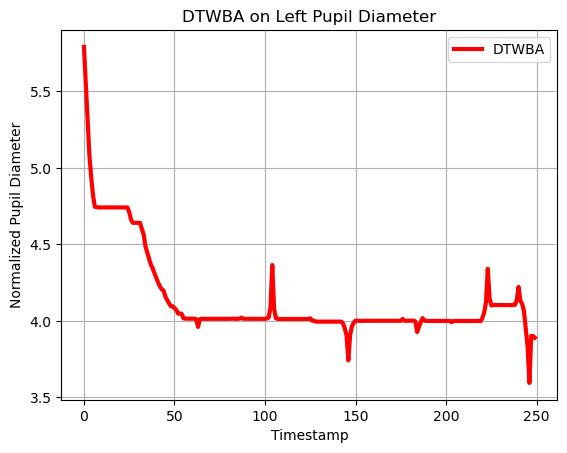

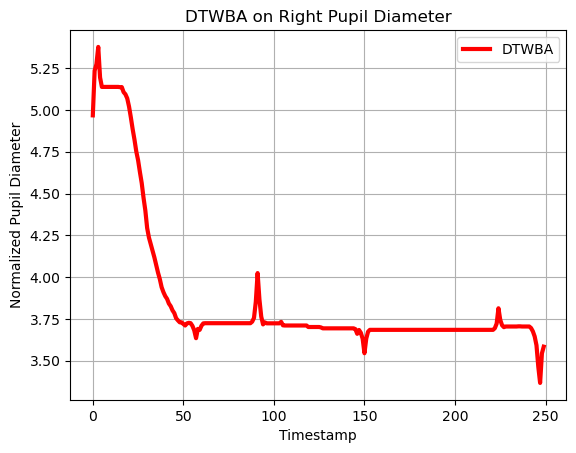

[Info] Experiment 0, Color Combination 0, Participant 3 with Participant 4: Done
[Info] Left EER: 0.0, Right EER: 0.0


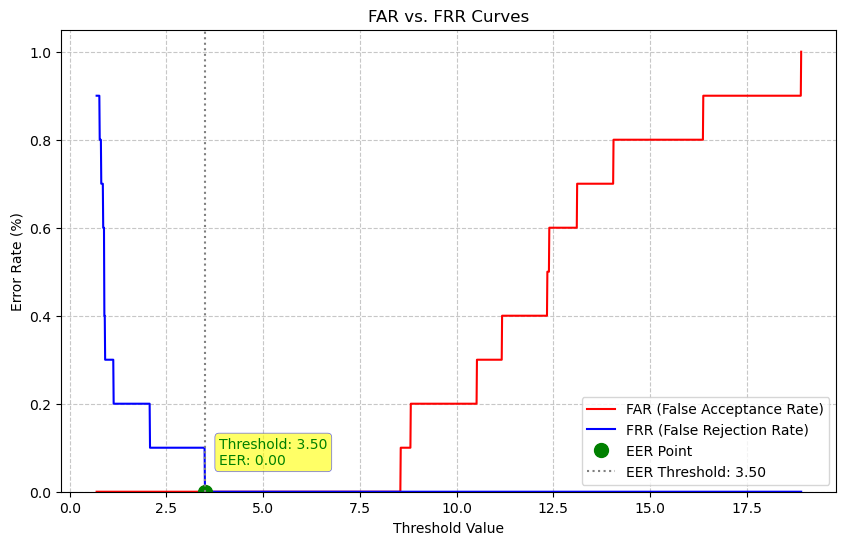

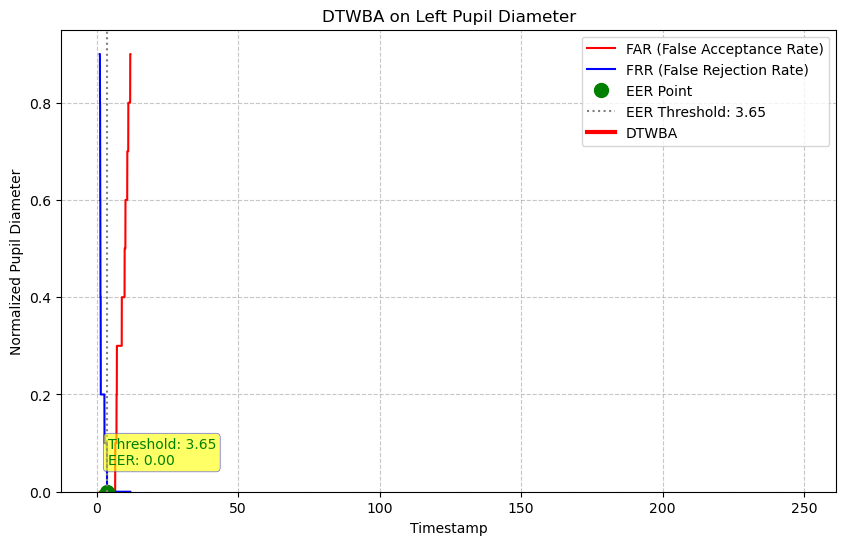

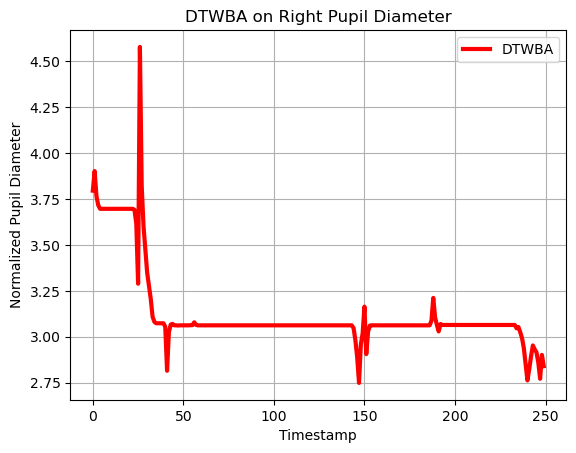

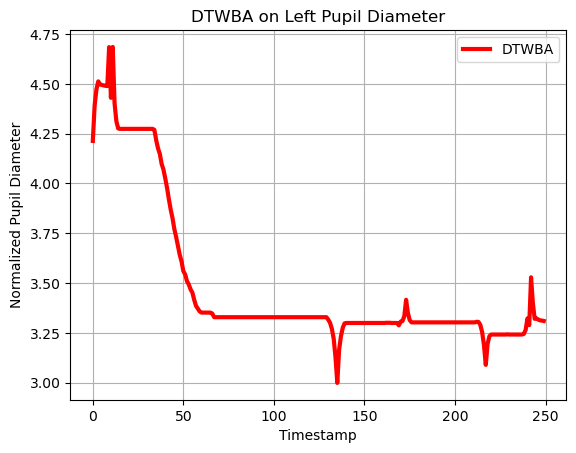

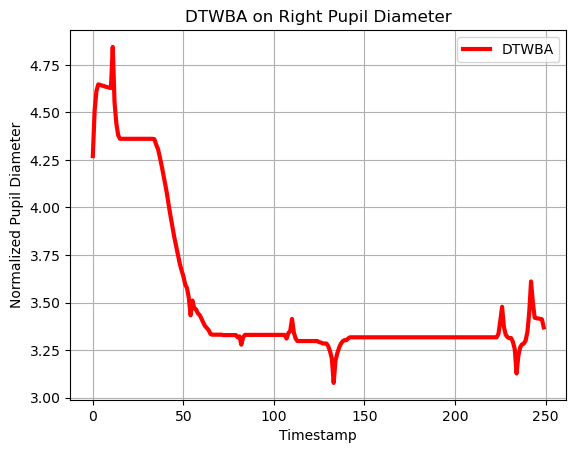

[Info] Experiment 0, Color Combination 0, Participant 3 with Participant 5: Done
[Info] Left EER: 0.2, Right EER: 0.1
[Info] participant_index: 3: Done


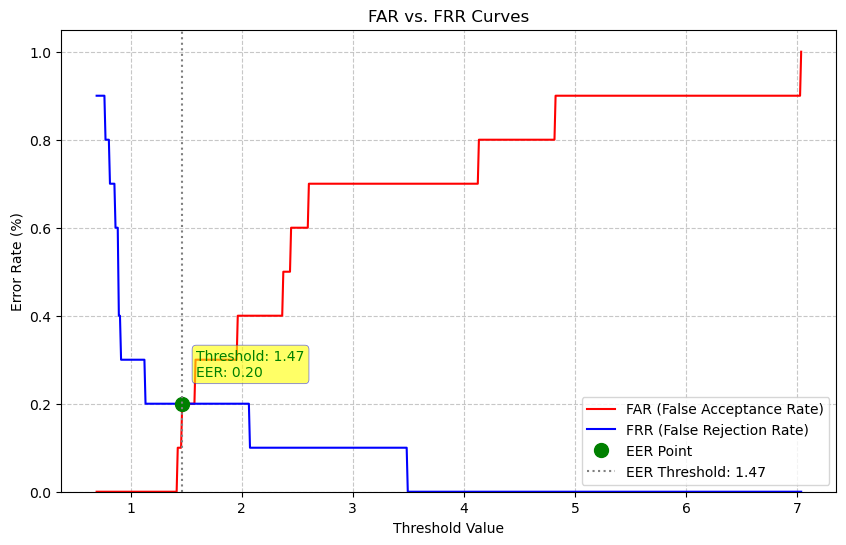

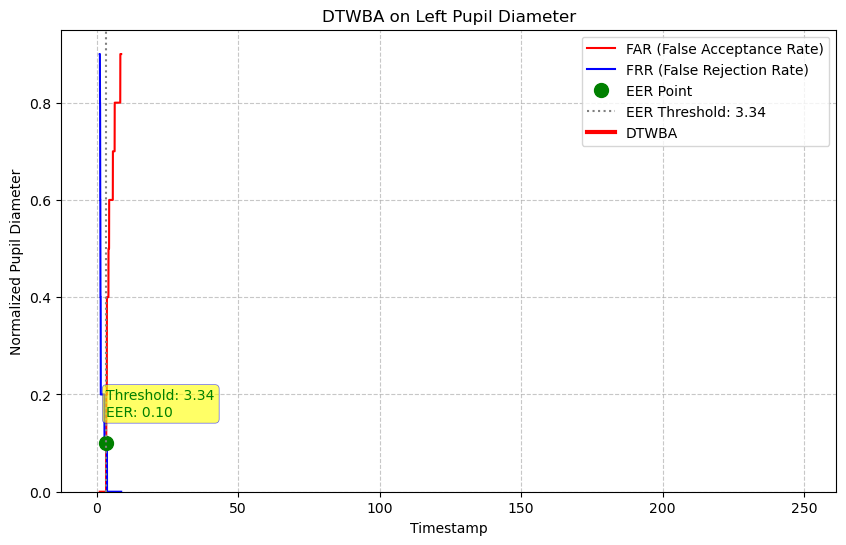

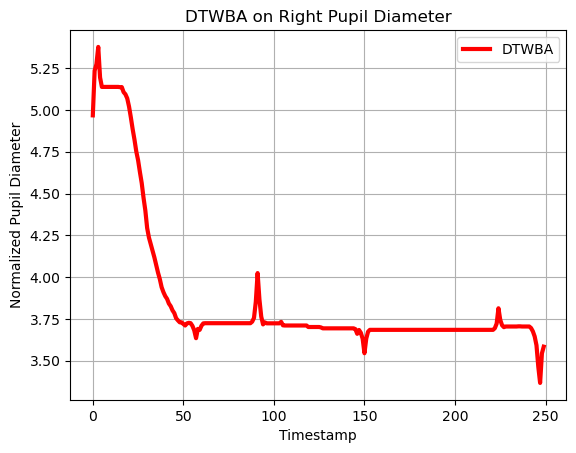

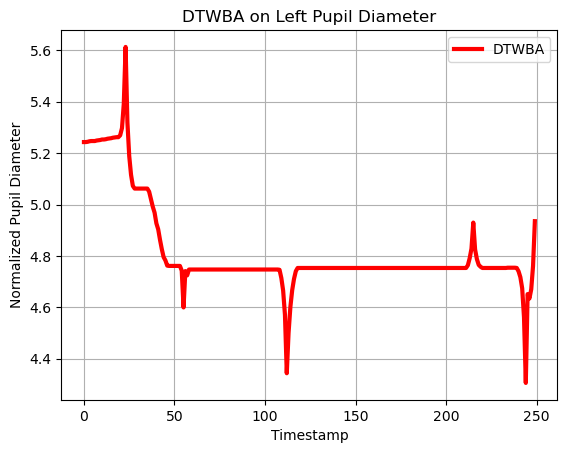

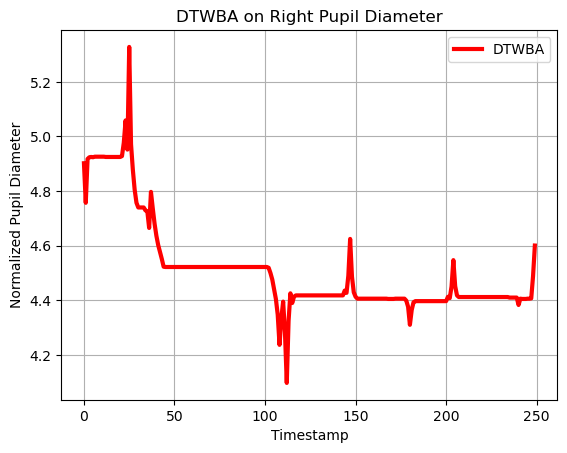

[Info] Experiment 0, Color Combination 0, Participant 4 with Participant 0: Done
[Info] Left EER: 0.0, Right EER: 0.0


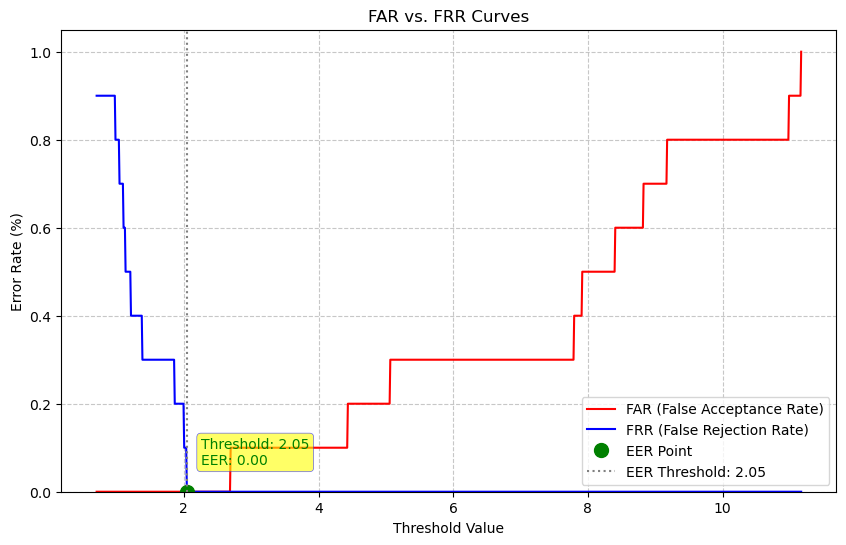

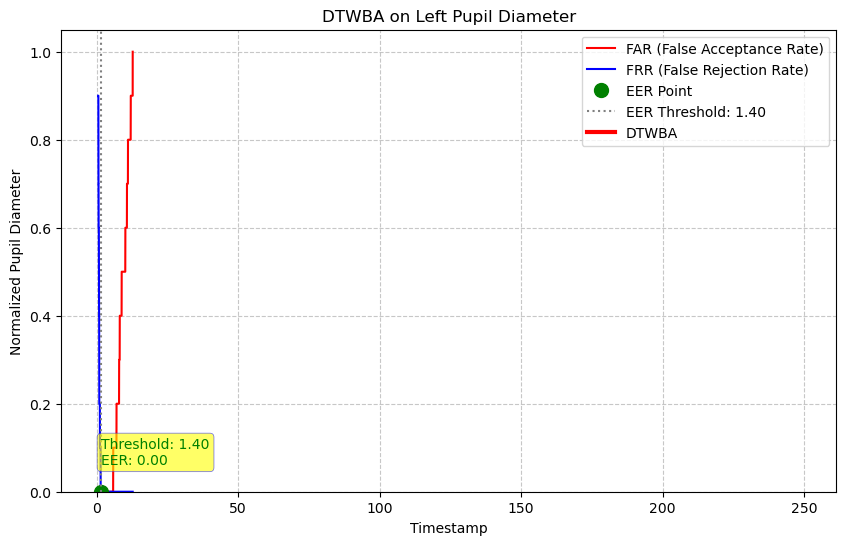

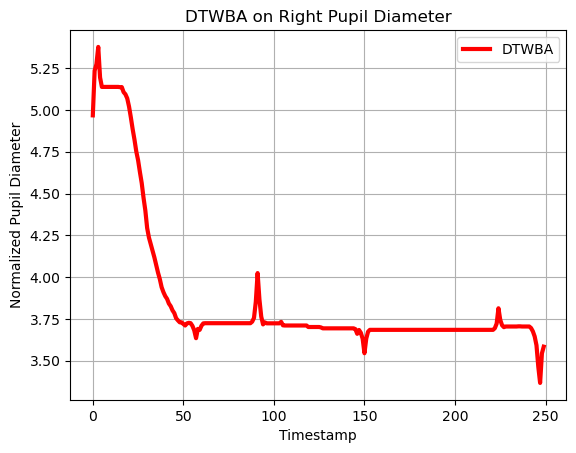

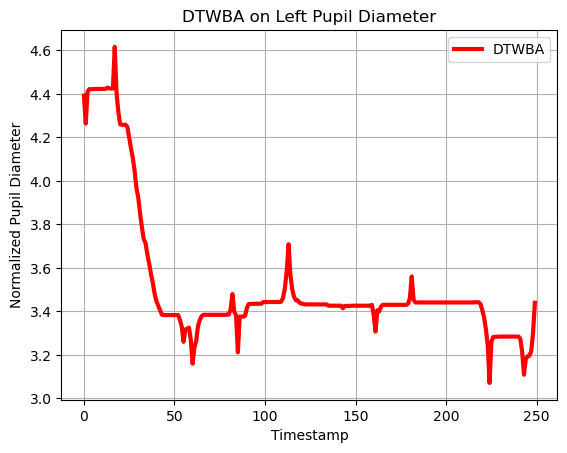

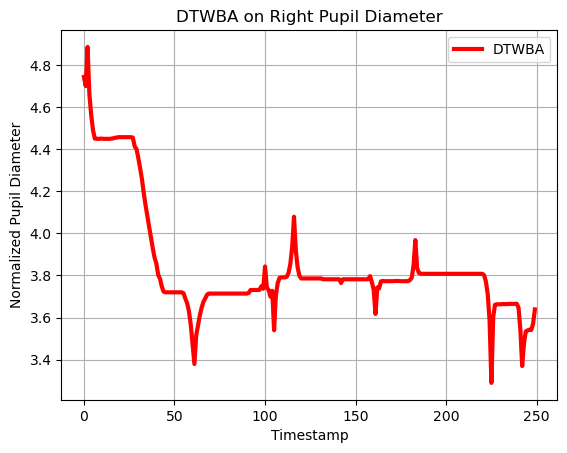

[Info] Experiment 0, Color Combination 0, Participant 4 with Participant 1: Done
[Info] Left EER: 0.0, Right EER: 0.1


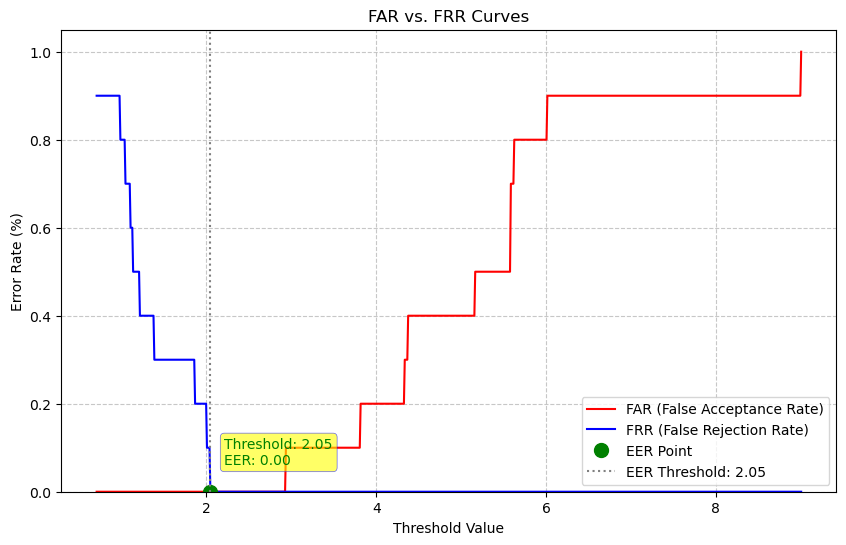

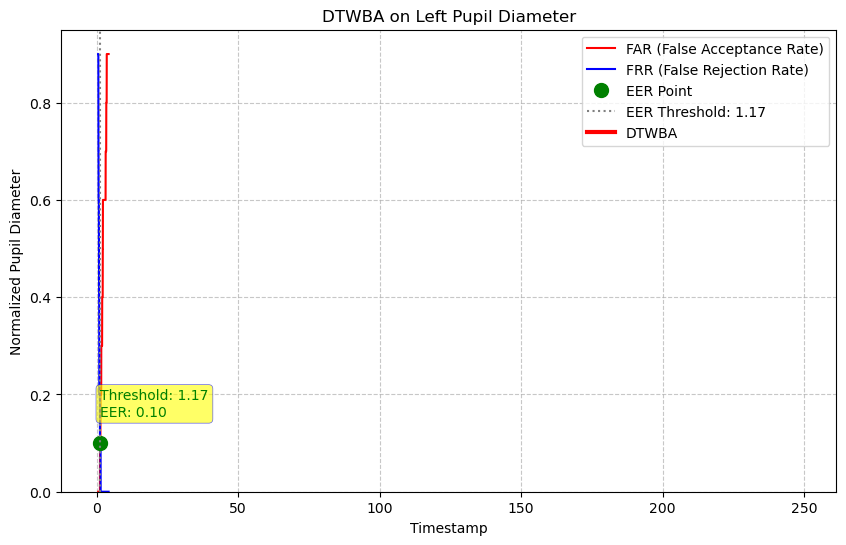

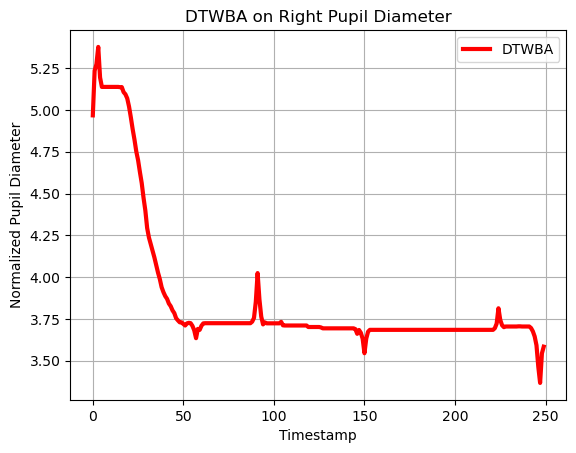

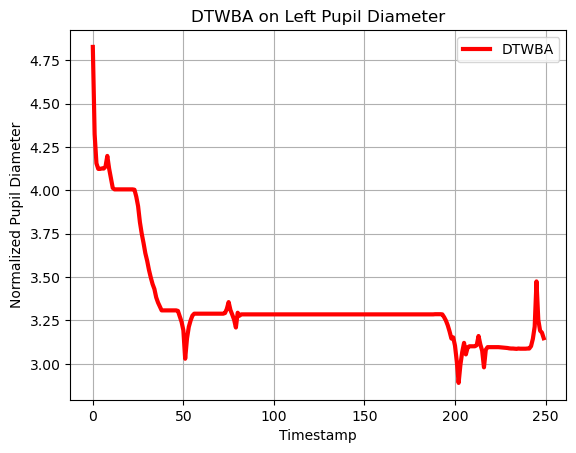

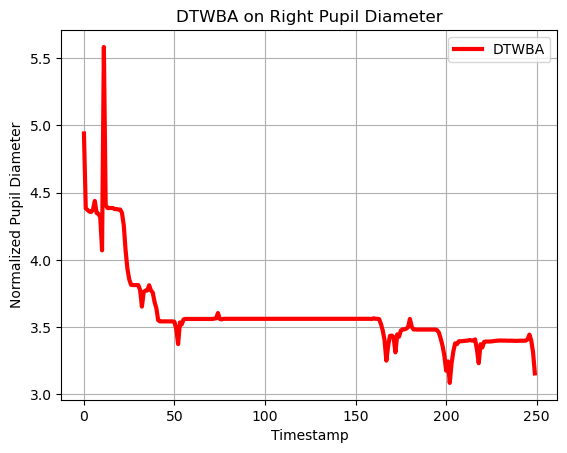

[Info] Experiment 0, Color Combination 0, Participant 4 with Participant 2: Done
[Info] Left EER: 0.0, Right EER: 0.1


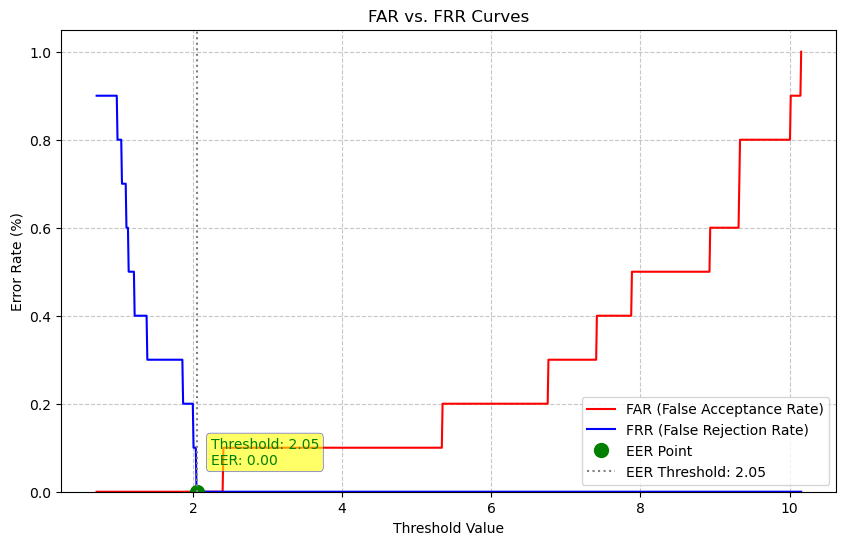

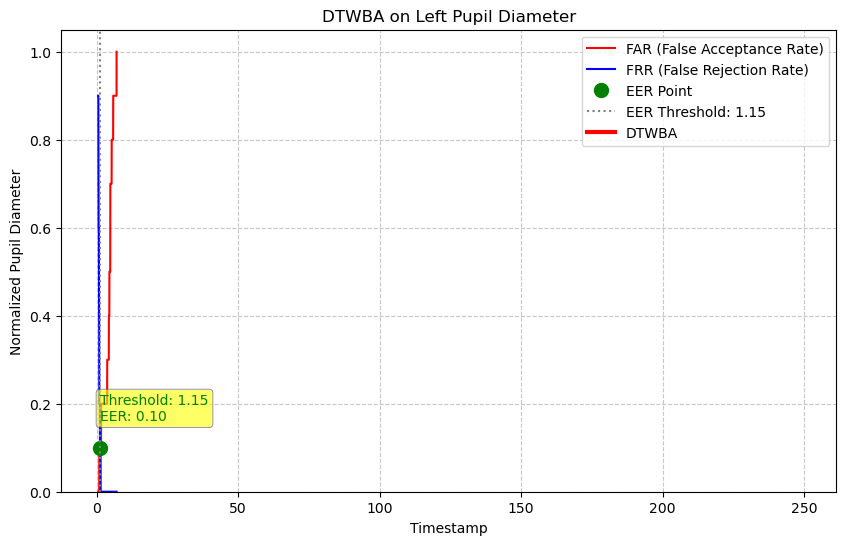

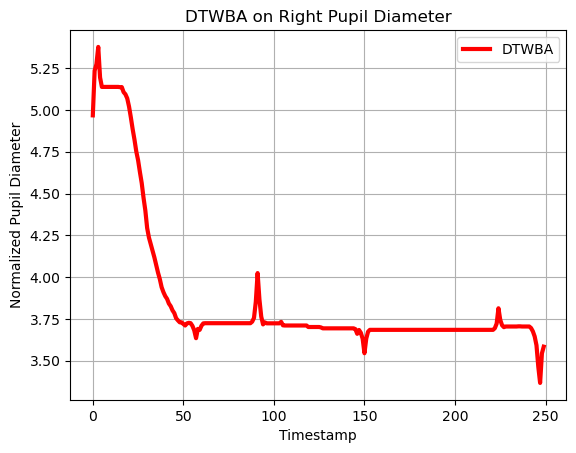

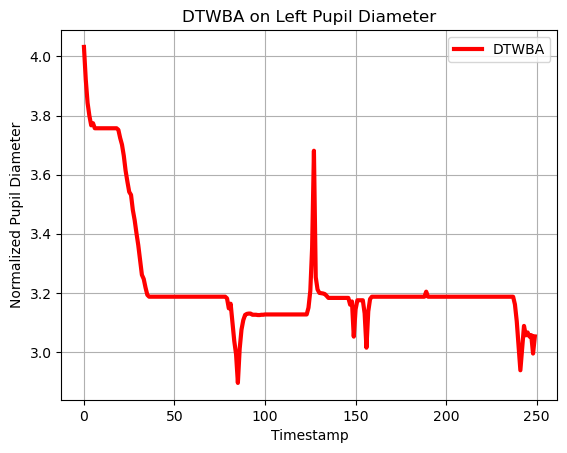

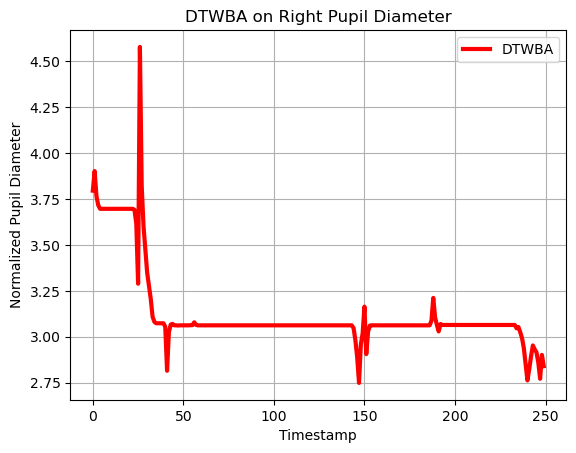

[Info] Experiment 0, Color Combination 0, Participant 4 with Participant 3: Done
[Info] Left EER: 0.0, Right EER: 0.0


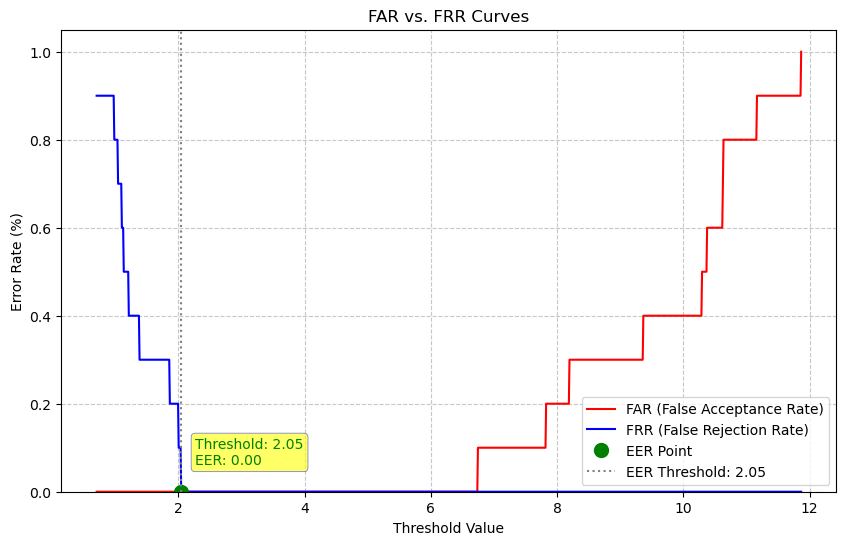

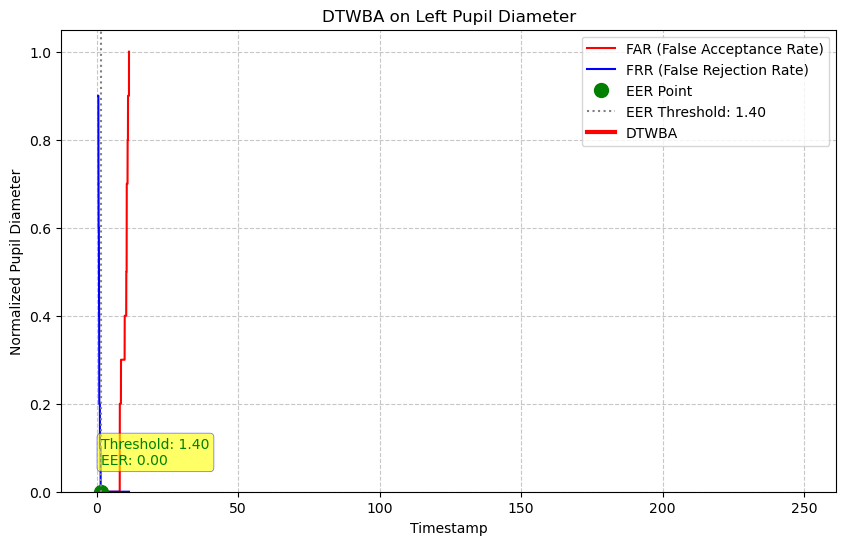

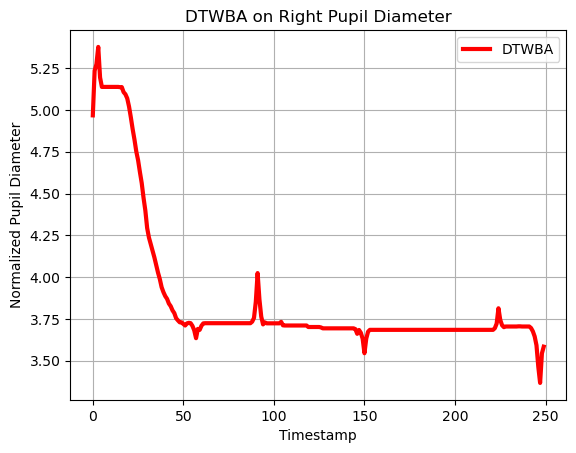

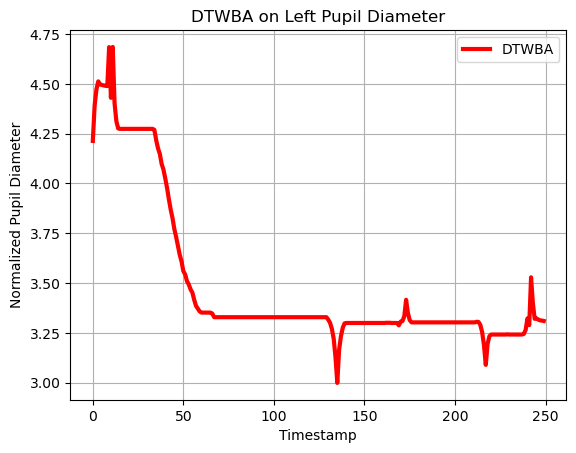

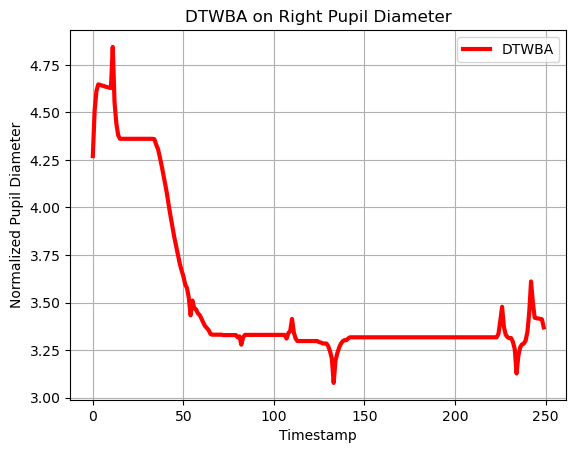

[Info] Experiment 0, Color Combination 0, Participant 4 with Participant 5: Done
[Info] Left EER: 0.0, Right EER: 0.0
[Info] participant_index: 4: Done


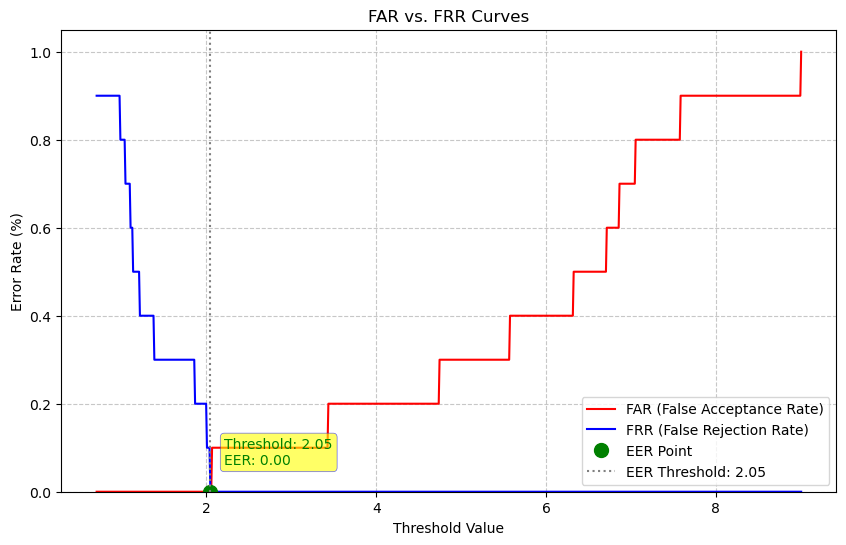

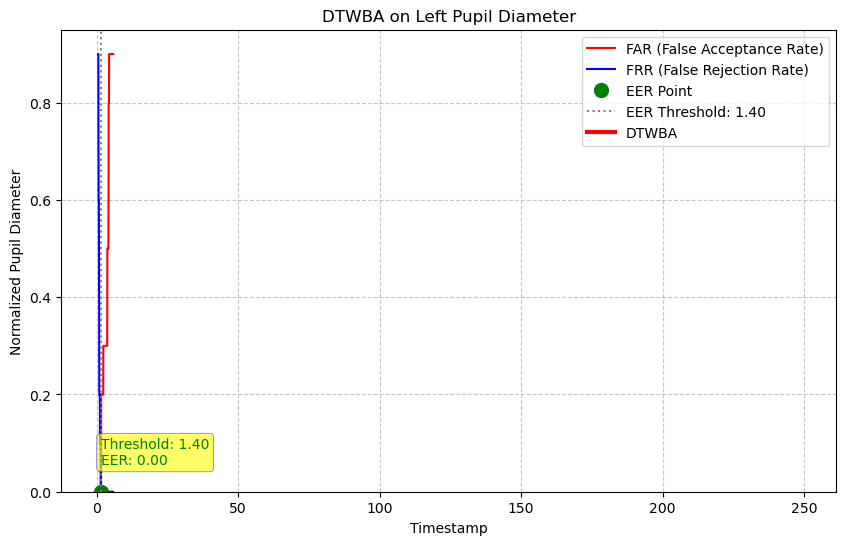

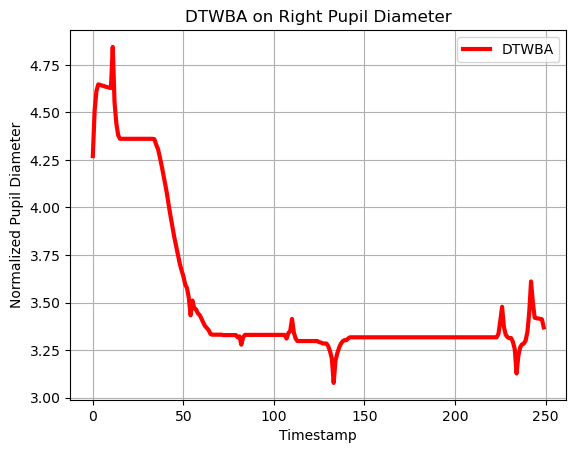

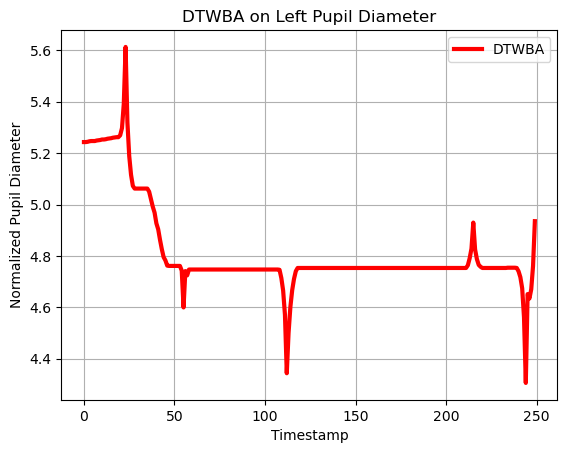

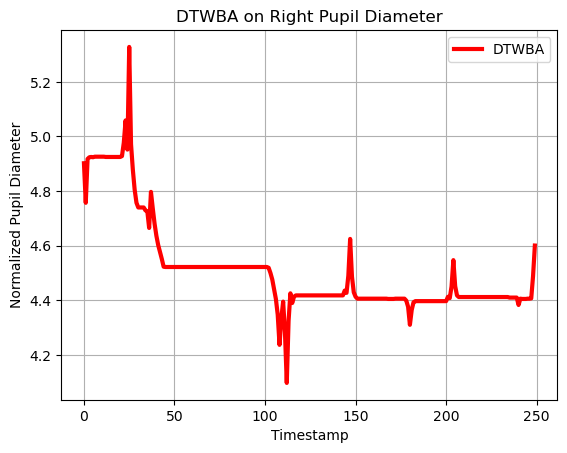

[Info] Experiment 0, Color Combination 0, Participant 5 with Participant 0: Done
[Info] Left EER: 0.0, Right EER: 0.0


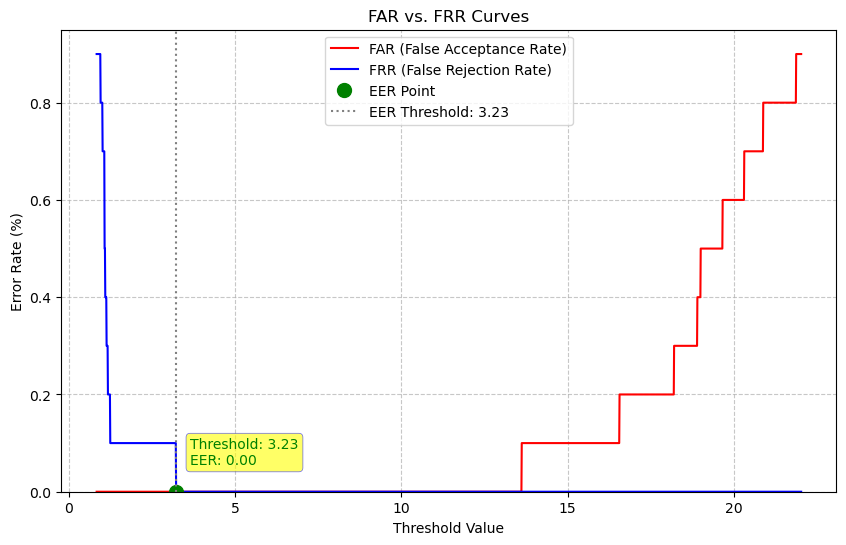

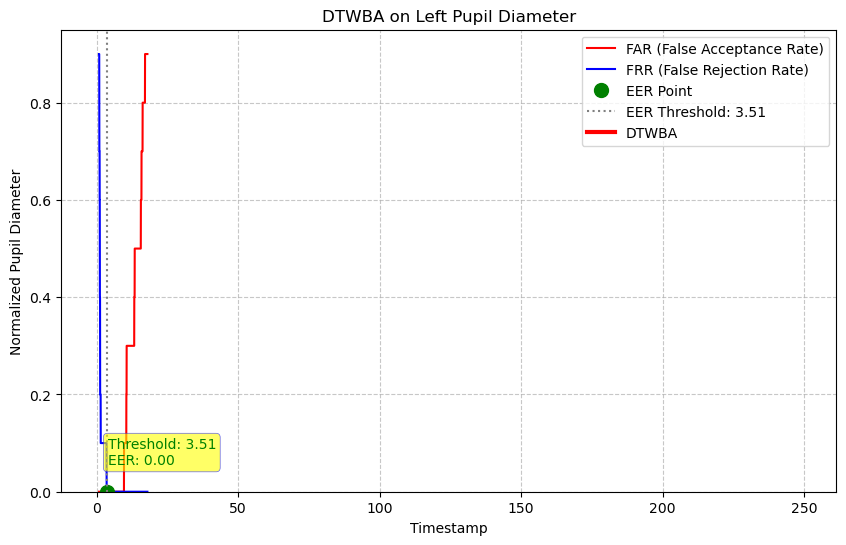

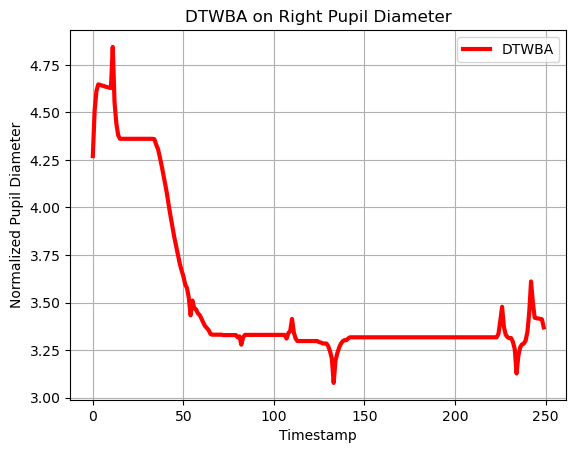

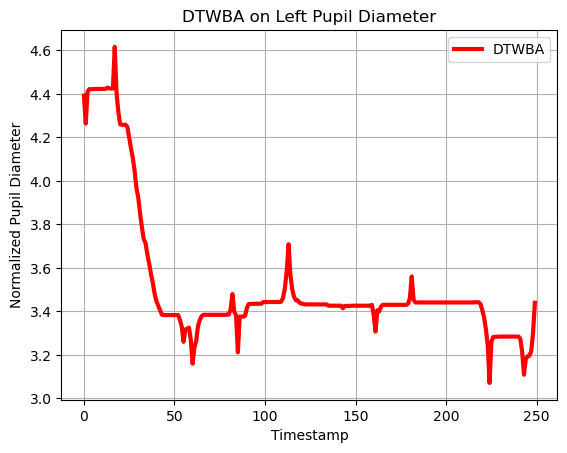

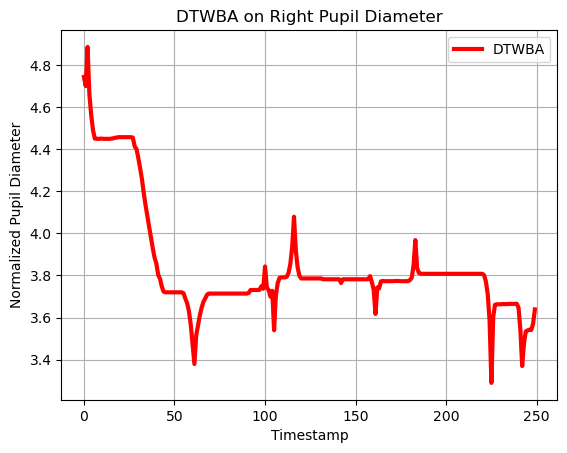

[Info] Experiment 0, Color Combination 0, Participant 5 with Participant 1: Done
[Info] Left EER: 0.3, Right EER: 0.1


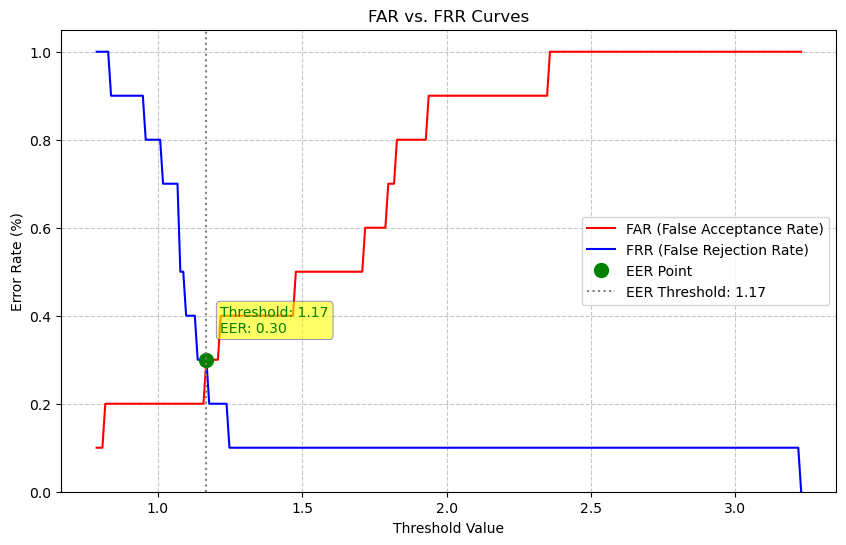

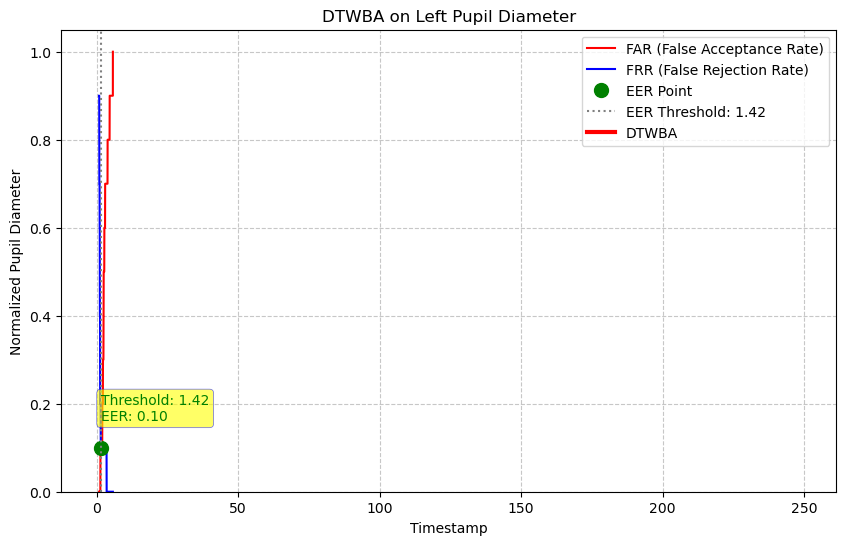

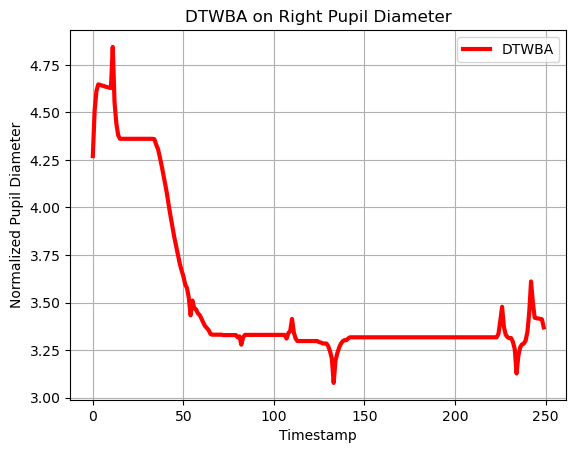

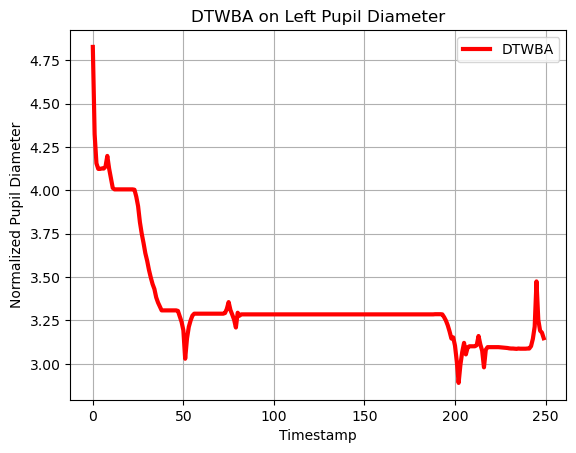

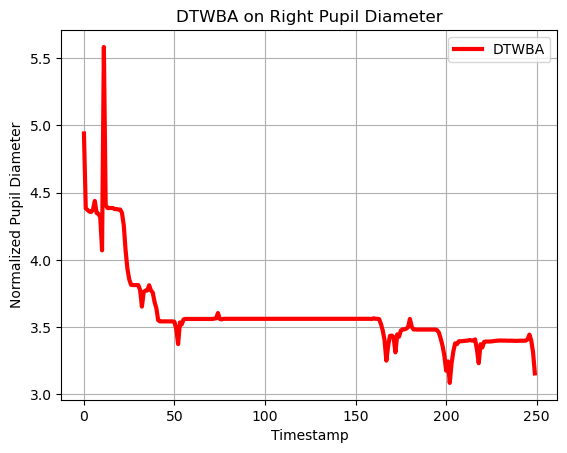

[Info] Experiment 0, Color Combination 0, Participant 5 with Participant 2: Done
[Info] Left EER: 0.1, Right EER: 0.2


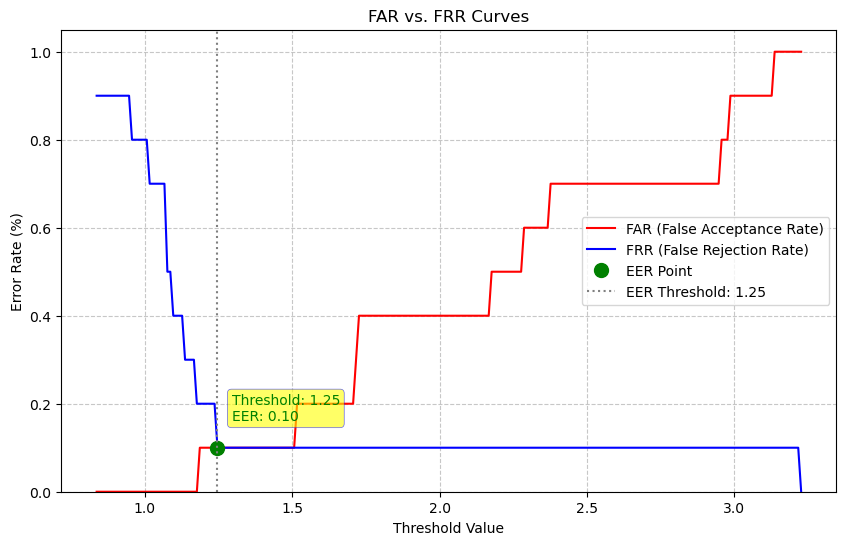

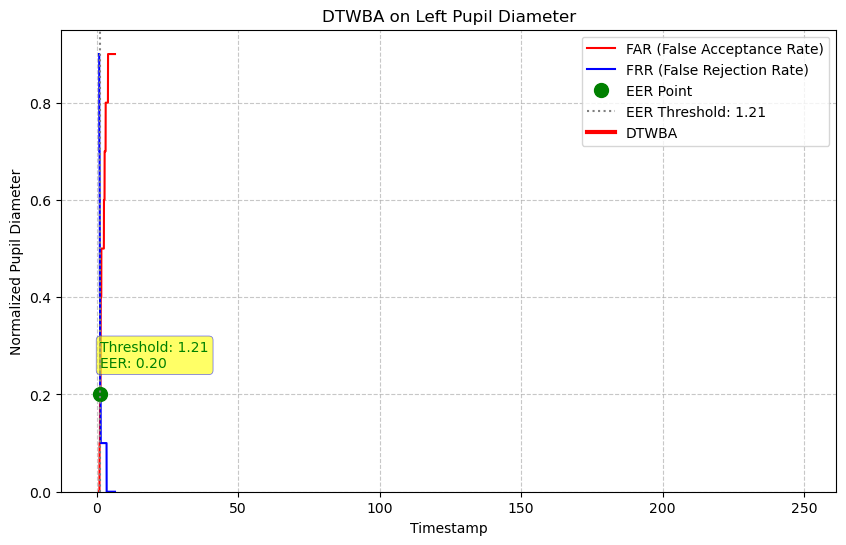

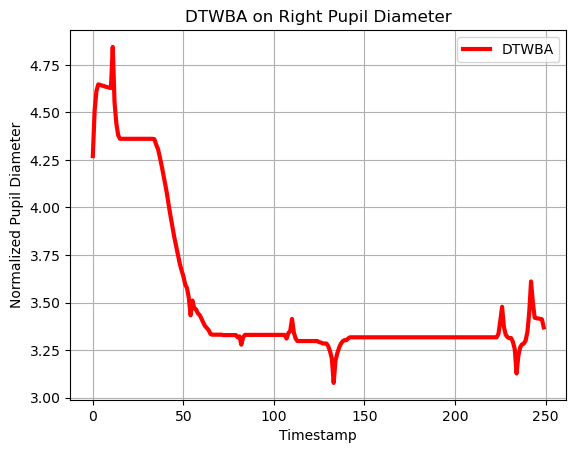

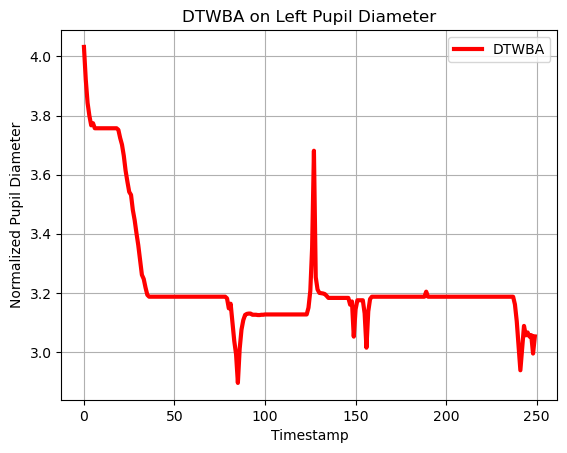

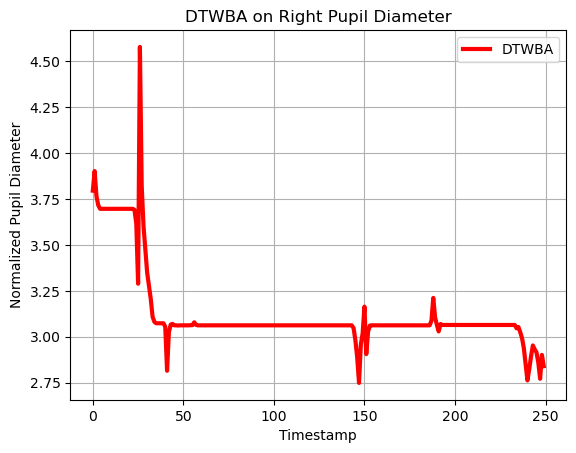

[Info] Experiment 0, Color Combination 0, Participant 5 with Participant 3: Done
[Info] Left EER: 0.1, Right EER: 0.0


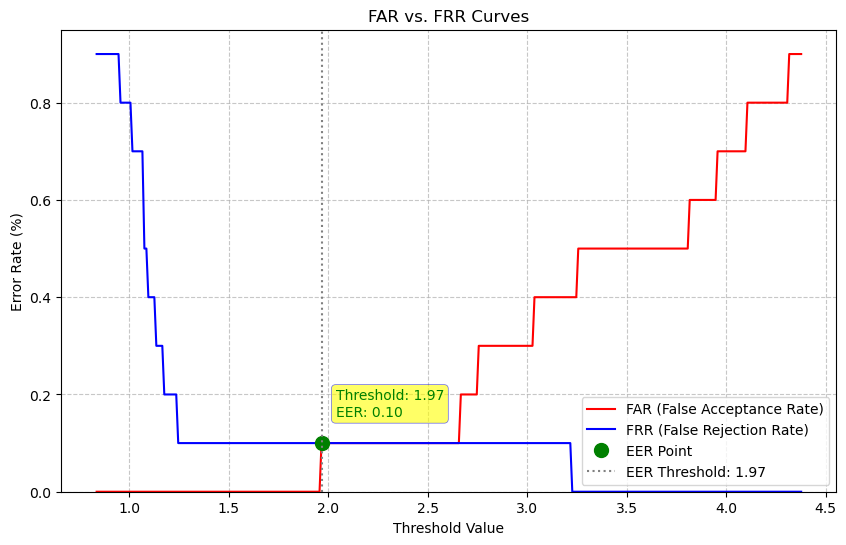

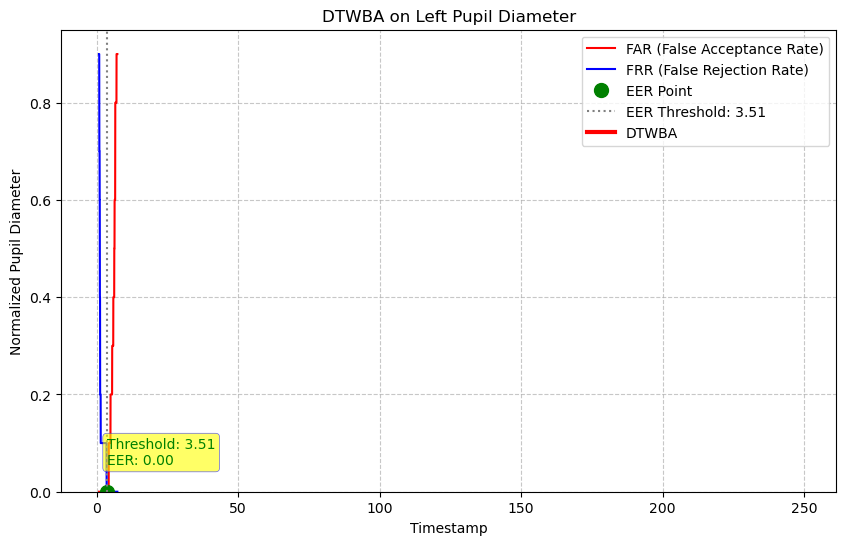

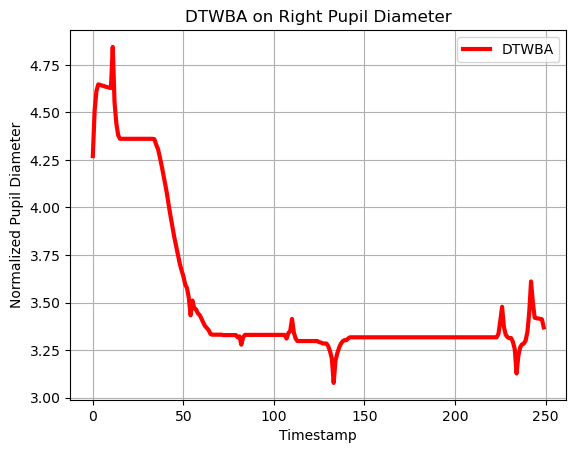

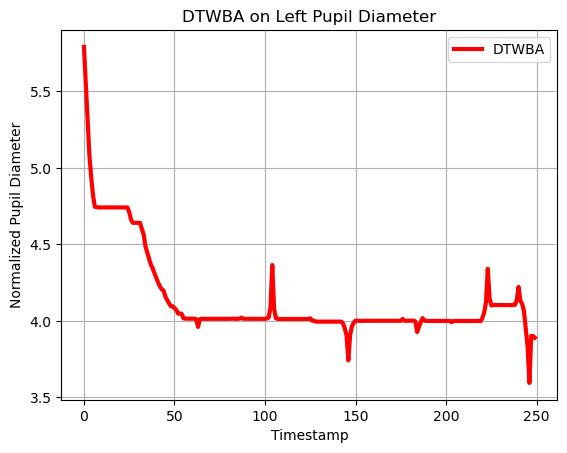

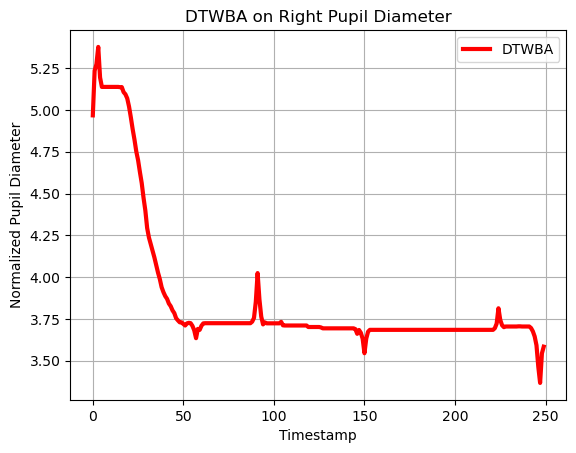

[Info] Experiment 0, Color Combination 0, Participant 5 with Participant 4: Done
[Info] Left EER: 0.0, Right EER: 0.1
[Info] participant_index: 5: Done
[Info] color_index: 0: Done


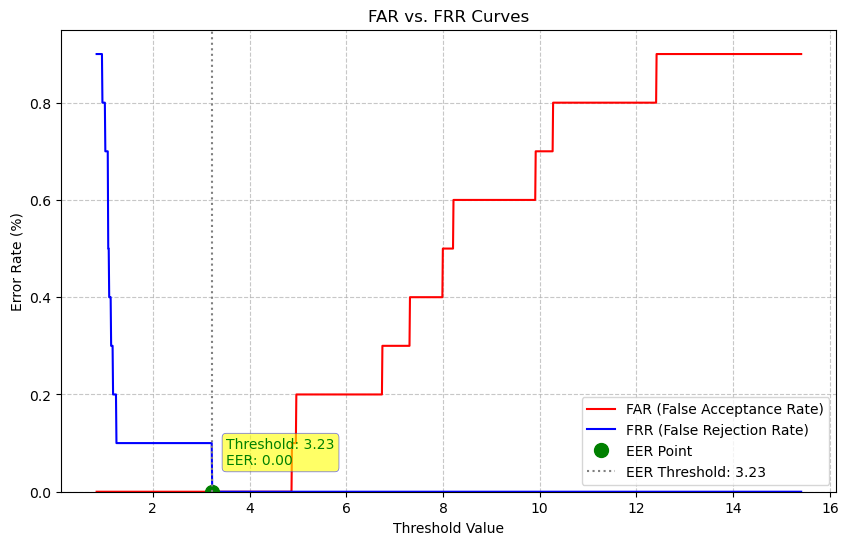

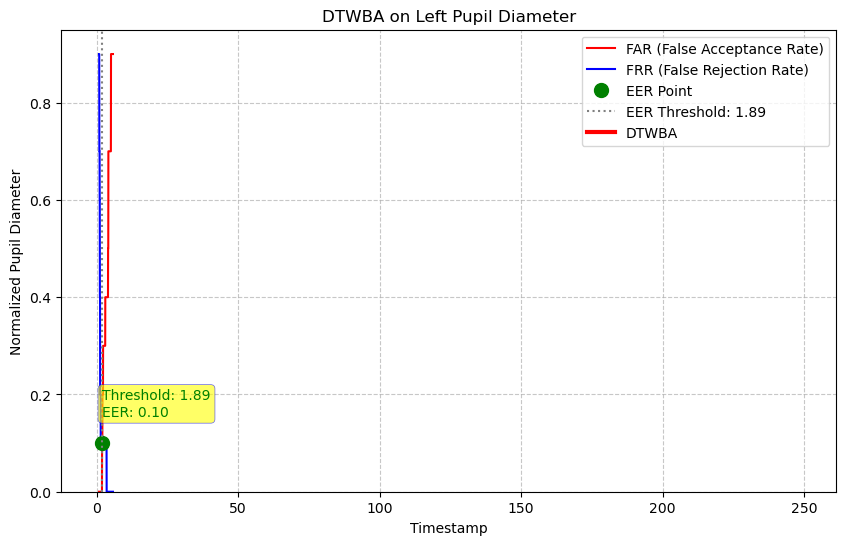

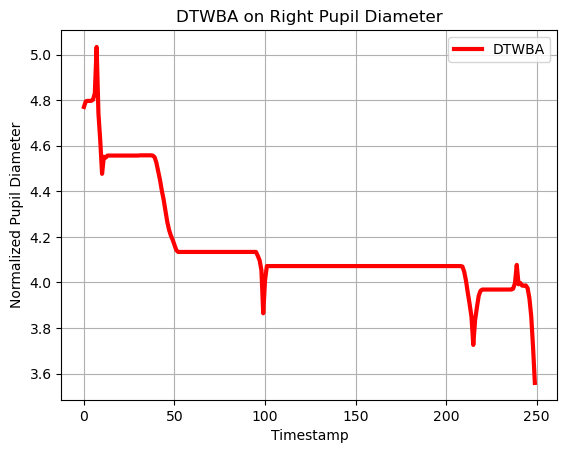

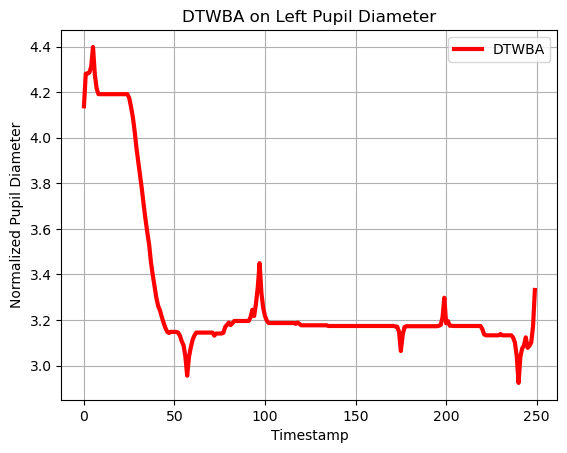

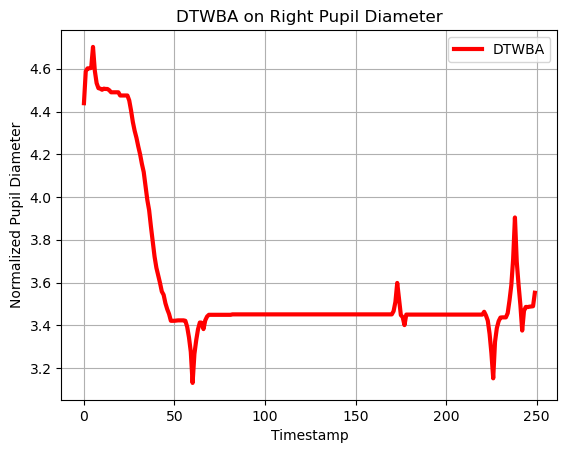

In [ ]:
get_all_EER()

In [ ]:
# with open("EER_data.json", 'w') as f:
#     # indent=4 で整形して読みやすくする
#     json.dump(EER, f, indent=4)

In [ ]:
with open("EER_data.json", 'r') as f:
        eer_data_from_json = json.load(f)

## Two-side EER

In [ ]:
# EER values vary in four experiments

for experiment_index in range(number_of_experiments):
    sum_of_EER = 0
    for color_combination_index in range(number_of_color_combinations):
        for participant_index in range(number_of_participants):
            for comparison_index in range(number_of_participants - 1):
                current_EER = EER[experiment_index][color_combination_index][participant_index][comparison_index]
                average_of_left_and_right = (current_EER[0] + current_EER[1]) / 2
                sum_of_EER = sum_of_EER + average_of_left_and_right
        # print(f"experiment_index is {experiment_index}, color_combination_index is {color_combination_index}, sum_of_EER is {sum_of_EER}")
    print(f"[Info] The average EER of experiment {experiment_index} is {sum_of_EER / (number_of_color_combinations * number_of_participants * (number_of_participants - 1))}")

In [ ]:
# EER values vary in four color combinations
sums = [0] * number_of_color_combinations

for experiment_index in range(number_of_experiments):
    for color_combination_index in range(number_of_color_combinations):    
        for participant_index in range(number_of_participants):
            for comparison_index in range(number_of_participants - 1):
                current_EER = EER[experiment_index][color_combination_index][participant_index][comparison_index]
                average_of_left_and_right = (current_EER[0] + current_EER[1]) / 2
                sums[color_combination_index] += average_of_left_and_right
          
divisor = number_of_experiments * number_of_participants * (number_of_participants - 1)
for i in range(number_of_color_combinations):
    average_EER = sums[i] / divisor
    print(f"[Info] The average EER of color combination {i+1} is {average_EER}")

## Left EER

In [ ]:
# EER values vary in four experiments

for experiment_index in range(number_of_experiments):
    sum_of_EER = 0
    for color_combination_index in range(number_of_color_combinations):
        for participant_index in range(number_of_participants):
            for comparison_index in range(number_of_participants - 1):
                left_EER = EER[experiment_index][color_combination_index][participant_index][comparison_index][0]
                sum_of_EER = sum_of_EER + left_EER
        # print(f"experiment_index is {experiment_index}, color_combination_index is {color_combination_index}, sum_of_EER is {sum_of_EER}")
    print(f"[Info] The average EER of experiment {experiment_index} is {sum_of_EER / (number_of_color_combinations * number_of_participants * (number_of_participants - 1))}")

In [ ]:
# EER values vary in four color combinations
sums = [0] * number_of_color_combinations

for experiment_index in range(number_of_experiments):
    for color_combination_index in range(number_of_color_combinations):    
        for participant_index in range(number_of_participants):
            for comparison_index in range(number_of_participants - 1):
                left_EER = EER[experiment_index][color_combination_index][participant_index][comparison_index][0]
                sums[color_combination_index] += left_EER
          
divisor = number_of_experiments * number_of_participants * (number_of_participants - 1)
for i in range(number_of_color_combinations):
    average_EER = sums[i] / divisor
    print(f"[Info] The average EER of color combination {i+1} is {average_EER}")

## Right EER

In [ ]:
# EER values vary in four experiments

for experiment_index in range(number_of_experiments):
    sum_of_EER = 0
    for color_combination_index in range(number_of_color_combinations):
        for participant_index in range(number_of_participants):
            for comparison_index in range(number_of_participants - 1):
                left_EER = EER[experiment_index][color_combination_index][participant_index][comparison_index][1]
                sum_of_EER = sum_of_EER + left_EER
        # print(f"experiment_index is {experiment_index}, color_combination_index is {color_combination_index}, sum_of_EER is {sum_of_EER}")
    print(f"[Info] The average EER of experiment {experiment_index} is {sum_of_EER / (number_of_color_combinations * number_of_participants * (number_of_participants - 1))}")

In [ ]:
# EER values vary in four color combinations
sums = [0] * number_of_color_combinations

for experiment_index in range(number_of_experiments):
    for color_combination_index in range(number_of_color_combinations):    
        for participant_index in range(number_of_participants):
            for comparison_index in range(number_of_participants - 1):
                left_EER = EER[experiment_index][color_combination_index][participant_index][comparison_index][1]
                sums[color_combination_index] += left_EER
          
divisor = number_of_experiments * number_of_participants * (number_of_participants - 1)
for i in range(number_of_color_combinations):
    average_EER = sums[i] / divisor
    print(f"[Info] The average EER of color combination {i+1} is {average_EER}")

## Specific Pattern

In [ ]:
# EER values vary in four color combinations
sums = [[0] * number_of_experiments for _ in range(number_of_participants)]

for experiment_index in range(number_of_experiments):
    for color_combination_index in range(number_of_color_combinations):    
        for participant_index in range(number_of_participants):
            for comparison_index in range(number_of_participants - 1):
                current_EER = EER[experiment_index][color_combination_index][participant_index][comparison_index]
                average_of_left_and_right = (current_EER[0] + current_EER[1]) / 2
                sums[participant_index][experiment_index] += average_of_left_and_right

divisor = number_of_color_combinations * (number_of_participants - 1)
for participant_index in range(number_of_participants):
    for experiment_index in range(number_of_experiments):
        average_EER = sums[participant_index][experiment_index] / divisor
        print(f"[Info] The average EER of participant {participant_index} for experiment {experiment_index} is {average_EER}")